# Urban Simulation - London Underground

## 0. Preliminary Step

#### Packages

In [1]:
# count running time
import time
start_time = time.time()

In [2]:
# import libraries
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats
from math import sqrt
from operator import itemgetter

#### Data Import

In [3]:
# london tube graph
G = nx.read_graphml("london.graph")

In [4]:
type(G)

networkx.classes.graph.Graph

In [5]:
print(nx.info(G))

Graph with 401 nodes and 467 edges


/tmp/ipykernel_753/2606185536.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


#### Constructing the Tube Networks

In [6]:
# check node attributes
list(G.nodes(data=True))[0]

('Waterloo', {'coords': '(530974.0910233686, 179921.09873829264)'})

In [7]:
# The coords are stored in a string format, need to convert them to tuples using eval().
for n in G.nodes():
    G.nodes[n]["coords"] = eval(G.nodes[n]["coords"])

In [8]:
# check node attribute. see its no longer a string
list(G.nodes(data=True))[0]

('Waterloo', {'coords': (530974.0910233686, 179921.09873829264)})

In [9]:
# This time, check edge attributes
list(G.edges(data=True))[0:2]

[('Waterloo',
  'Bank and Monument',
  {'length': 2542.954443856927,
   'line_name': 'Waterloo & City',
   'flows': 255934}),
 ('Waterloo',
  'Embankment',
  {'length': 769.4283320889193, 'line_name': 'Bakerloo', 'flows': 25666})]

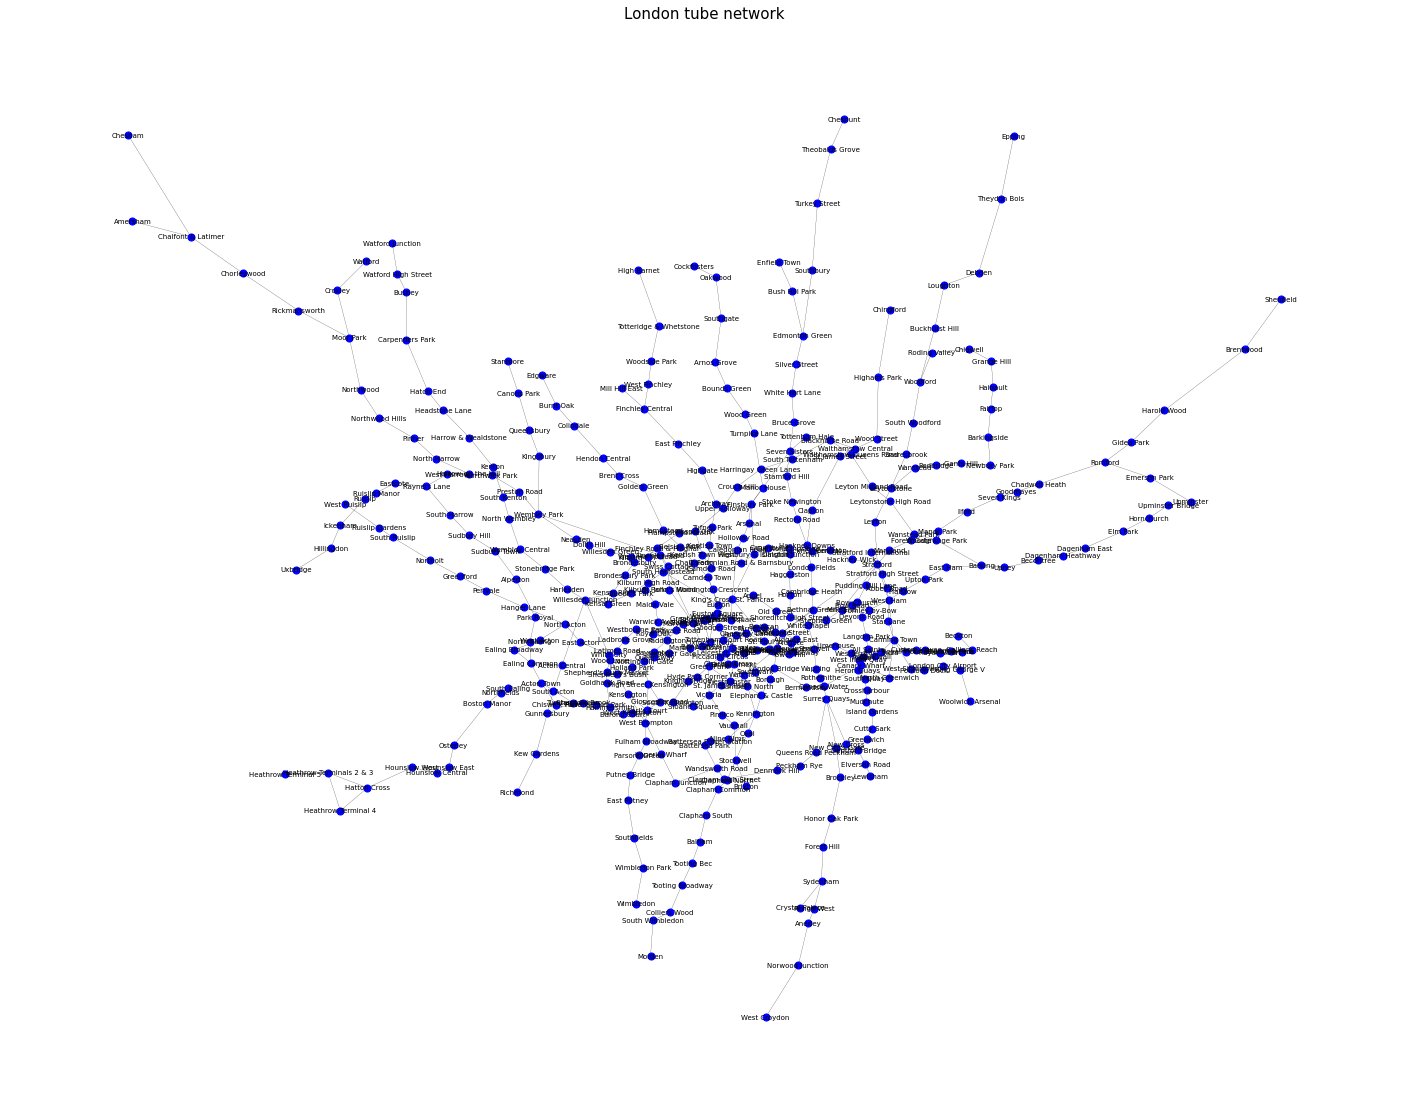

In [10]:
# Let's plot the tube network! 

# We can plot the tube network with the names of the stations as labels
fig, ax = plt.subplots(figsize=(25,20))

pos = nx.get_node_attributes(G, 'coords')

nx.draw_networkx_nodes(G, pos, node_size = 50, node_color ='b')
nx.draw_networkx_edges(G, pos, arrows = False, width = 0.2)
nx.draw_networkx_labels(G, pos, font_size = 7, font_color='black')

plt.title("London tube network",fontsize=15)
plt.axis("off")
plt.show()

In [11]:
# We can print the dataframe from the shapefile to check the data
df = nx.to_pandas_edgelist(G)
df[0:10]

,source,target,length,line_name,flows
0,Waterloo,Bank and Monument,2542.954444,Waterloo & City,255934
1,Waterloo,Embankment,769.428332,Bakerloo,25666
2,Waterloo,Kennington,1760.198517,Northern,58310
3,Waterloo,Lambeth North,573.689056,Bakerloo,2339
4,Waterloo,Southwark,656.426930,Jubilee,10312
5,Waterloo,Westminster,850.360026,Jubilee,195879
6,Bank and Monument,Shadwell,2317.101464,DLR,20708
7,Bank and Monument,Cannon Street,329.312716,District,16126
8,Bank and Monument,Tower Hill,839.730443,District,23456
9,Bank and Monument,Moorgate,776.829461,Northern,70400


In [12]:
# check degree distribution
deg_df = pd.DataFrame(list(nx.degree(G)), columns=['Node', 'Degree'])
deg_df

,Node,Degree
0,Waterloo,6
1,Bank and Monument,8
2,Brixton,1
3,Stockwell,4
4,Vauxhall,2
...,...,...
396,Northwick Park,2
397,Preston Road,2
398,Croxley,2
399,Watford,1


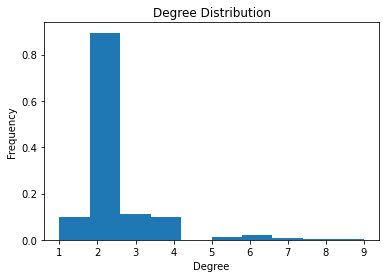

In [13]:
# Degree Distribution
plt.hist(deg_df['Degree'], density=True)

plt.title('Degree Distribution')
plt.ylabel("Frequency")
plt.xlabel("Degree")

plt.show()

## 1. Topological Network

### 1.1. Centrality measures

**3 centrality measures - rank top 10 tube stations** 

- Give the definition of each of the measures (including their equation).
- Put the measures into the context of the underground.
- Explain why they will allow you to find the stations that are most crucial for the functioning of the underground.

#### 1.1.1. Degree centrality

In [14]:
# degree centrality
degree_london = nx.degree_centrality(G)
# add the between attributs to the network G and name it 'betweenes_t'
nx.set_node_attributes(G, dict(degree_london), "degree")
# make a dictionary and sort it in a descending order 
dict_degree = {k: v for k, v in sorted(degree_london.items(), key=lambda x: x[1], reverse=True)}

# To dataframe
degree_df = pd.DataFrame.from_dict(dict_degree, orient='index')
degree_df.rename(columns={0: "Degree Centrality"}, inplace=True)
degree_df.head(10)

,Degree Centrality
Stratford,0.0225
Bank and Monument,0.0200
King's Cross St. Pancras,0.0175
Baker Street,0.0175
Waterloo,0.0150
Green Park,0.0150
Oxford Circus,0.0150
West Ham,0.0150
Canning Town,0.0150
Liverpool Street,0.0150


In [15]:
# Lets set colour and size of nodes according to degree centrality values
#degree_values=[(i[1]['degree']) for i in G.nodes(data=True)]

# set colour and size
#deg_color = [(i[1]['degree']/(max(degree_values))) for i in G.nodes(data=True)]
#deg_size = [(i[1]['degree']/(max(degree_values)))*50 for i in G.nodes(data=True)]

# Plot graph

#pos=pos

#fig, ax = plt.subplots(figsize=(12,12))

#nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.4)
#nod = nx.draw_networkx_nodes(G, pos = pos, node_color= deg_color, node_size= deg_size)

#plt.colorbar(nod, label = "Degree Centrality", orientation = "horizontal", shrink = 0.5)
#plt.axis("off")
#plt.title("London Tube Degree Centrality", fontsize = 15)
#plt.show()

#### 1.1.2. Topological Closeness Centrality

In [16]:
# topological closeness centrality
# if parameter "distance" is all edges have a distance of 1
# if we consider that distance between tube station is 1
# then Green Park is the main influencer as it is the very centre of London
# so the distance to every other nodes is the smallest from this station
clos_t = nx.closeness_centrality(G, distance = None)

# add the between attributs to the network G and name it 'betweenes_t'
nx.set_node_attributes(G, dict(clos_t), "closeness_t")

# make a dictionary and sort it in a descending order 
dict_clos_t = {k: v for k, v in sorted(clos_t.items(), key=lambda x: x[1], reverse=True)}

# To dataframe
t_closeness_df = pd.DataFrame.from_dict(dict_clos_t, orient='index')
t_closeness_df.rename(columns={0: "Topological Closeness Centrality"}, inplace=True)
t_closeness_df.head(10)

,Topological Closeness Centrality
Green Park,0.114778
Bank and Monument,0.113572
King's Cross St. Pancras,0.113443
Westminster,0.112549
Waterloo,0.112265
Oxford Circus,0.111204
Bond Street,0.110988
Farringdon,0.110742
Angel,0.110742
Moorgate,0.110314


In [17]:
# Lets set color and width of nodes according to the closeness values
#clos_t_val=[(i[1]['closeness_t']) for i in G.nodes(data=True)]

#closs_t_color = [(i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val)) for i in G.nodes(data=True)]
#closs_t_size = [((i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val))*50) for i in G.nodes(data=True)]


# Plot graph
#fig, ax = plt.subplots(figsize=(12,12))

#nx.draw_networkx_edges(G, pos, edge_color = 'gray', width=0.4)

#nod=nx.draw_networkx_nodes(G, pos = pos, node_color = closs_t_color, node_size= closs_t_size)

#plt.colorbar(nod, label = "Closeness Centrality", orientation = "horizontal", shrink = 0.5)
#plt.axis("off")
#plt.title("London Tube Topological Closeness Centrality", fontsize = 15)
#plt.show()

#### 1.1.3. Topological Betweenness Centrality

In [18]:
### Topological betweenness centrality:
# Let us compute the betweenness centrality for the network, without using weights:
# all edge weights are considered equal
# as we do not consider weight between two tube stations (source and destination)
# all we care about is arriving at our destination with an aim to stop over less station
# as distance between each station is 1
bet_london_t = nx.betweenness_centrality(G, normalized=False)
# add the between attributs to the network G and name it 'betweenes_t'
nx.set_node_attributes(G, dict(bet_london_t), "betweeness_t")
# make a dictionary and sort it in a descending order 
dict_bet_t = {k: v for k, v in sorted(bet_london_t.items(), key=lambda x: x[1], reverse=True)}

# To dataframe
t_betweenness_df = pd.DataFrame.from_dict(dict_bet_t, orient='index')
t_betweenness_df.rename(columns={0: "Topological Betweenness Centrality"}, inplace=True)
t_betweenness_df.head(10)

,Topological Betweenness Centrality
Stratford,23768.093434
Bank and Monument,23181.058947
Liverpool Street,21610.387049
King's Cross St. Pancras,20373.521465
Waterloo,19464.882323
Green Park,17223.622114
Euston,16624.275469
Westminster,16226.155916
Baker Street,15287.107612
Finchley Road,13173.758009


In [19]:
# Lets set colour and size of nodes according to betweenness values
#betweenness_t_values=[(i[1]['betweenness_t']) for i in G.nodes(data=True)]

#bet_t_color=[(i[1]['betweenness_t']/max(betweenness_t_values)) for i in G.nodes(data=True)]
#bet_t_size=[(i[1]['betweenness_t']/max(betweenness_t_values))*100 for i in G.nodes(data=True)]

# Plot graph
#fig, ax = plt.subplots(figsize=(12,12))

#nx.draw_networkx_edges(G, pos, edge_color = 'gray', width = 0.4)
#nod=nx.draw_networkx_nodes(G, pos = pos, node_color = bet_t_color, node_size = bet_t_size)

#plt.colorbar(nod, label = "Betweenness Centrality", orientation = "horizontal", shrink = 0.5)
#plt.axis("off")
#plt.title("London Tube Topological Betweenness Centrality", fontsize = 15)
#plt.show()

### 1.2. Impact measures

Q2. Find 2 different global measures to evaluate the impact of the node removal on the network.

What could be the possible measures that could assess the impacts of node removal?

- Diameter (Week 6): If there is a disruption in the passage which passes important nodes, the longest shortest path in the graph would likely increase.

- **Average of the shortest path (Week 6)**: This measure calculates the mean shortest distance for all pairs of nodes. The removal of important nodes would likely result in an increase in the average shortest path for remaining nodes.

- **Number of components (Week 7)**: If the number of components of the networks increases, it indicates that there is an increase in the number of disconnected components in the networks. Therefore, this can be a measure to assess the impacts of node removal.

- Clustering coefficient (Week 7): The more disconnected the networks are, the lower the clustering coefficient is.

- Degree distribution (Week 9): The important nodes would be stations which are a changing station to many other lines. This means that their degree would be bigger than 1, whilst many other tube stations have 1 or 2. The removal of these important nodes would transform the shape of the degree distribution but the impact could be mild.

### 1.3. Node removal

A) Non-sequential removal: remove 1 node at a time following the rank in the table

B) Sequential: remove the highest ranked node and evaluate the impact using the 2 measures. After removal, recompute the centrality measure. Remove the highest ranked node in the new network and evaluate the impact. Continue until removing at least 10 nodes. 

Report the results of the 2 strategies in one plot, and critically discuss the following: which centrality measure 
reflects better the importance of a station for the functioning of the underground, which strategy is more effective at studying resilience, and which impact measure is better at assessing the damage after node removal. 

#### Default values of the original networks

In [20]:
# Number of components in the tube networks
original_components = len(sorted(nx.connected_components(G), key=len, reverse=True))
original_components

1

In [21]:
# Average shortest path, average distance between any two nodes
original_avg_short_path = nx.average_shortest_path_length(G)
original_avg_short_path

13.545997506234414

In [22]:
# Original size
original_size = len(G.nodes)
original_size

401

In [23]:
# Original diameter, longest shortest path
original_diameter = nx.diameter(G)
original_diameter

36

In [24]:
# Average clustering coefficient
original_avg_clus_coef = nx.average_clustering(G)
original_avg_clus_coef

0.030382377389858686

In [25]:
original_normalised_size = (original_size/original_size)
original_normalised_avg_short_path = original_avg_short_path/original_size

In [26]:
# Customised function
def impact_assess(graph):
    '''
    This function assess the impacts of node removals.
    6 metrics are calculated. 
    Tube stations whose centrality measure was based on 
    closeness centrality has one connected component until the 9th node removal.
    Therefore, in order to avoid errors, the codes for estimating metrics of interest 
    are also specified when num_components == 1.
    '''
    # number of components
    num_components = len(sorted(nx.connected_components(graph), key=len, reverse=True))

    # graph is connected
    if num_components == 1:
        # Original size
        size = graph.number_of_nodes()
        # average shortest path
        avg_short_path = nx.average_shortest_path_length(graph)
        # diameter
        diameter = nx.diameter(graph)
        # To compute average clustering coefficient
        avg_clus_coef = nx.average_clustering(graph)
    
    # graph is not connected
    else:
        # Get the list of components:
        components = nx.connected_components(graph)
       
        # Use the max() command to find the largest one:
        largest_component = max(components, key=len)

        # Create a "subgraph" of the largest component
        largest_subgraph = graph.subgraph(largest_component)

        # To coumpute the size of the largest component:
        size = largest_subgraph.number_of_nodes()
        
        # To compute the average shortest path
        avg_short_path = nx.average_shortest_path_length(largest_subgraph)
        
        # To compute diameter
        diameter = nx.diameter(largest_subgraph)
        
        # To compute average clustering coefficient
        avg_clus_coef = nx.average_clustering(largest_subgraph)
        
    # calculate the ratio of nodes present in the largest connected components
    normalised_size = size/original_size
    normalised_avg_short_path = avg_short_path/size # size of the largest component

    return num_components, size, avg_short_path, diameter, avg_clus_coef, normalised_size, normalised_avg_short_path
    

#### 1.3.1 Non-sequential removal (Strategy A)

In [27]:
def non_sequential(graph, station_list):
    '''
    This function displays potential impacts of top 10 tube stations removal
    according to their ranking. The removal strategy follows non sequential node removal strategy.
    At each node removal step, its impact is evaluated.    
    '''
    results = {}
    results['Original'] = [original_components, original_size, original_avg_short_path, original_diameter,
                          original_avg_clus_coef, original_normalised_size, original_normalised_avg_short_path]

    for station in station_list:
        graph.remove_node(station)
        num_components, size, avg_short_path, diameter, avg_clus_coef, normalised_size, normalised_avg_short_path = impact_assess(graph)
        results[station] = [num_components, size, avg_short_path, diameter, avg_clus_coef, normalised_size, normalised_avg_short_path]

    
    return results

In [28]:
# Degree Centrality
# new graph
G_degree_A = G.copy()

# a list of top 10 degree tube stations
stations_top_10_deg = degree_df.index.tolist()[:10]

# Apply a function
df_degree_A = pd.DataFrame.from_dict(non_sequential(G_degree_A, stations_top_10_deg), orient = 'index',
                                         columns = ['Number of Components (A)', 'Size of Largest Component (A)', 
                                                  'Average Shortest Path (A)', 'Diameter (A)', 'Average Clustering Coef (A)', 
                                                    'Normalised Size (A)', 'Normalised Average Shortest Path (A)'])  
df_degree_A.reset_index(inplace = True)
df_degree_A.rename(columns = {'index':'Removed Station (A)'}, inplace = True)
df_degree_A                                  

,Removed Station (A),Number of Components (A),Size of Largest Component (A),Average Shortest Path (A),Diameter (A),Average Clustering Coef (A),Normalised Size (A),Normalised Average Shortest Path (A)
0,Original,1,401,13.545998,36,0.030382,1.000000,0.033781
1,Stratford,3,379,14.496447,49,0.032322,0.945137,0.038249
2,Bank and Monument,3,378,14.872497,49,0.031696,0.942643,0.039345
3,King's Cross St. Pancras,3,377,16.054927,49,0.031957,0.940150,0.042586
4,Baker Street,4,374,17.013376,49,0.028966,0.932668,0.045490
5,Waterloo,4,373,17.608810,50,0.027882,0.930175,0.047209
6,Green Park,4,372,17.852477,51,0.026344,0.927681,0.047991
7,Oxford Circus,5,370,17.912737,51,0.028288,0.922693,0.048413
8,West Ham,6,367,18.618365,53,0.025341,0.915212,0.050731
9,Canning Town,9,352,18.419160,53,0.026420,0.877805,0.052327


In [29]:
# Topological closeness centrality
# new graph
G_clos_A = G.copy()

# a list of top 10 closeness tube stations
stations_top_10_clos = t_closeness_df.index.tolist()[:10]

# Apply a function
df_clos_A = pd.DataFrame.from_dict(non_sequential(G_clos_A, stations_top_10_clos), orient = 'index',
                                         columns = ['Number of Components (A)', 'Size of Largest Component (A)', 
                                                  'Average Shortest Path (A)', 'Diameter (A)', 
                                                  'Average Clustering Coef (A)', 'Normalised Size (A)', 'Normalised Average Shortest Path (A)'])  
df_clos_A.reset_index(inplace = True)
df_clos_A.rename(columns = {'index':'Removed Station (A)'}, inplace = True)
df_clos_A     

,Removed Station (A),Number of Components (A),Size of Largest Component (A),Average Shortest Path (A),Diameter (A),Average Clustering Coef (A),Normalised Size (A),Normalised Average Shortest Path (A)
0,Original,1,401,13.545998,36,0.030382,1.000000,0.033781
1,Green Park,1,400,13.824536,36,0.029792,0.997506,0.034561
2,Bank and Monument,1,399,14.382728,38,0.029276,0.995012,0.036047
3,King's Cross St. Pancras,1,398,15.983773,42,0.029517,0.992519,0.040160
4,Westminster,1,397,16.080248,42,0.028080,0.990025,0.040504
5,Waterloo,1,396,16.855722,42,0.028151,0.987531,0.042565
6,Oxford Circus,1,395,17.431832,45,0.029910,0.985037,0.044131
7,Bond Street,1,394,17.464267,45,0.030034,0.982544,0.044326
8,Farringdon,1,393,17.462494,45,0.030110,0.980050,0.044434
9,Angel,1,392,17.460528,45,0.030187,0.977556,0.044542


In [30]:
# Topological betweenness centrality

# new graph
G_bet_A = G.copy()

# a list of top 10 betweenness tube stations
stations_top_10_bet = t_betweenness_df.index.tolist()[:10]

# Apply a function
df_bet_A = pd.DataFrame.from_dict(non_sequential(G_bet_A, stations_top_10_bet), orient = 'index',
                                         columns = ['Number of Components (A)', 'Size of Largest Component (A)', 
                                                  'Average Shortest Path (A)', 'Diameter (A)', 
                                                  'Average Clustering Coef (A)', 'Normalised Size (A)', 'Normalised Average Shortest Path (A)'])  
df_bet_A.reset_index(inplace = True)
df_bet_A.rename(columns = {'index':'Removed Station (A)'}, inplace = True)
df_bet_A    

,Removed Station (A),Number of Components (A),Size of Largest Component (A),Average Shortest Path (A),Diameter (A),Average Clustering Coef (A),Normalised Size (A),Normalised Average Shortest Path (A)
0,Original,1,401,13.545998,36,0.030382,1.000000,0.033781
1,Stratford,3,379,14.496447,49,0.032322,0.945137,0.038249
2,Bank and Monument,3,378,14.872497,49,0.031696,0.942643,0.039345
3,Liverpool Street,3,377,15.031209,49,0.031780,0.940150,0.039871
4,King's Cross St. Pancras,4,371,16.030742,49,0.032473,0.925187,0.043210
5,Waterloo,4,370,16.756742,49,0.031390,0.922693,0.045288
6,Green Park,4,369,17.180865,49,0.030301,0.920200,0.046561
7,Euston,5,346,16.807372,49,0.028461,0.862843,0.048576
8,Westminster,5,345,16.975059,49,0.028544,0.860349,0.049203
9,Baker Street,6,342,17.586339,49,0.024756,0.852868,0.051422


#### 1.3.2 Sequential removal (Strategy B)

**Degree Centrality**

In [31]:
# Degree centrality
# load the tube station graph
G1 = G.copy()

# calculate the topological closeness centrality of each node in the network:
degree_cen = nx.degree_centrality(G1)

# Set the node attribute "closeness" to be the calculated topological closeness centrality:
nx.set_node_attributes(G1, dict(degree_cen), "degree")

# Original size
original_size = G1.number_of_nodes()

# calculate original metrics
num_components, size, avg_short_path, diameter, avg_clus_coef, normalised_size, normalised_avg_short_path = impact_assess(G1)

# create an empty dictionary to store the metrics
metrics_dict = {

    "Removed Station (B)": [],
    "Number of Components (B)": [],
    "Size of Largest Component (B)": [],
    "Average Shortest Path (B)": [],
    "Diameter (B)": [],
    "Average Clustering Coef (B)": [],
    "Normalised Size (B)": [],
    'Normalised Average Shortest Path (B)': []
}


# append original metrics to the dictionary
metrics_dict["Removed Station (B)"].append("Original")
metrics_dict["Number of Components (B)"].append(num_components)
metrics_dict["Size of Largest Component (B)"].append(size)
metrics_dict["Average Shortest Path (B)"].append(avg_short_path)
metrics_dict['Diameter (B)'].append(diameter)
metrics_dict["Average Clustering Coef (B)"].append(avg_clus_coef)
metrics_dict["Normalised Size (B)"].append(normalised_size)
metrics_dict["Normalised Average Shortest Path (B)"].append(normalised_avg_short_path)

for j in range(0, 10):

    # extract the topological closeness centrality values from each of prev calcluated degrees, pick the max
    degree_values = [(i[1]["degree"]) for i in G1.nodes(data=True)]
    maxdeg = [n for n in G1.nodes() if G1.nodes[n]["degree"] == max(degree_values)]

    # append to list of stations removed
    metrics_dict["Removed Station (B)"].append(maxdeg[0])

    # remove node:
    G1.remove_nodes_from([maxdeg[0]])
    # number of nodes after the removal
    print(len(list(G1.nodes)))

    # recalculate the topological closeness centrality using networkx function:
    degree_cen_new = nx.degree_centrality(G1)
    nx.set_node_attributes(G1, dict(degree_cen_new), "degree")

    # calculate the impact of the node removal
    num_components, size, avg_short_path, diameter, avg_clus_coef, normalised_size, normalised_avg_short_path = impact_assess(G1)

    metrics_dict["Number of Components (B)"].append(num_components)
    metrics_dict["Size of Largest Component (B)"].append(size)
    metrics_dict["Average Shortest Path (B)"].append(avg_short_path)
    metrics_dict['Diameter (B)'].append(diameter)
    metrics_dict["Average Clustering Coef (B)"].append(avg_clus_coef)
    metrics_dict["Normalised Size (B)"].append(normalised_size)
    metrics_dict["Normalised Average Shortest Path (B)"].append(normalised_avg_short_path)

    print(f"Iteration {j+1}: Station removed: {maxdeg[0]}, Number of Components: {num_components}, Size of Largest component: {size}, Average Shortest Path Length: {avg_short_path}, Diameter: [diameter], Average Clustering Coefficient: {avg_clus_coef}, Normalised Size: {normalised_size}%, Normalised Average Shortest Path: {normalised_avg_short_path}")

df_degree_B = pd.DataFrame.from_dict(metrics_dict)
df_degree_B

400
Iteration 1: Station removed: Stratford, Number of Components: 3, Size of Largest component: 379, Average Shortest Path Length: 14.496447069006436, Diameter: [diameter], Average Clustering Coefficient: 0.032321899736147755, Normalised Size: 0.9451371571072319%, Normalised Average Shortest Path: 0.03824920070977952
399
Iteration 2: Station removed: Bank and Monument, Number of Components: 3, Size of Largest component: 378, Average Shortest Path Length: 14.872496596634528, Diameter: [diameter], Average Clustering Coefficient: 0.031695641219450746, Normalised Size: 0.942643391521197%, Normalised Average Shortest Path: 0.03934522909162574
398
Iteration 3: Station removed: King's Cross St. Pancras, Number of Components: 3, Size of Largest component: 377, Average Shortest Path Length: 16.054926914611436, Diameter: [diameter], Average Clustering Coefficient: 0.03195654919792851, Normalised Size: 0.940149625935162%, Normalised Average Shortest Path: 0.042586013036104604
397
Iteration 4: St

,Removed Station (B),Number of Components (B),Size of Largest Component (B),Average Shortest Path (B),Diameter (B),Average Clustering Coef (B),Normalised Size (B),Normalised Average Shortest Path (B)
0,Original,1,401,13.545998,36,0.030382,1.000000,0.033781
1,Stratford,3,379,14.496447,49,0.032322,0.945137,0.038249
2,Bank and Monument,3,378,14.872497,49,0.031696,0.942643,0.039345
3,King's Cross St. Pancras,3,377,16.054927,49,0.031957,0.940150,0.042586
4,Baker Street,4,374,17.013376,49,0.028966,0.932668,0.045490
5,Green Park,4,373,17.175257,49,0.027882,0.930175,0.046046
6,Canning Town,6,359,17.531100,51,0.025720,0.895262,0.048833
7,Earl's Court,6,358,17.894731,51,0.018250,0.892768,0.049985
8,Waterloo,6,357,18.493501,51,0.016620,0.890274,0.051803
9,Oxford Circus,7,355,18.574966,51,0.018592,0.885287,0.052324


**Topological Closeness Centrality**

In [32]:
# load the tube station graph
G2 = G.copy()

# calculate the topological closeness centrality of each node in the network:
close_cen = nx.closeness_centrality(G2, distance = None)

# Set the node attribute "closeness" to be the calculated topological closeness centrality:
nx.set_node_attributes(G2, dict(close_cen), "closeness_t")

# Original size
original_size = G2.number_of_nodes()

# calculate original metrics
num_components, size, avg_short_path, diameter, avg_clus_coef, normalised_size, normalised_avg_short_path = impact_assess(G2)

# create an empty dictionary to store the metrics
metrics_dict = {

    "Removed Station (B)": [],
    "Number of Components (B)": [],
    "Size of Largest Component (B)": [],
    "Average Shortest Path (B)": [],
    "Diameter (B)": [],
    "Average Clustering Coef (B)": [],
    "Normalised Size (B)": [],
    'Normalised Average Shortest Path (B)': []
}


# append original metrics to the dictionary
metrics_dict["Removed Station (B)"].append("Original")
metrics_dict["Number of Components (B)"].append(num_components)
metrics_dict["Size of Largest Component (B)"].append(size)
metrics_dict["Average Shortest Path (B)"].append(avg_short_path)
metrics_dict['Diameter (B)'].append(diameter)
metrics_dict["Average Clustering Coef (B)"].append(avg_clus_coef)
metrics_dict["Normalised Size (B)"].append(normalised_size)
metrics_dict["Normalised Average Shortest Path (B)"].append(normalised_avg_short_path)

for j in range(0, 10):

    # extract the topological closeness centrality values from each of prev calcluated degrees, pick the max
    close_values = [(i[1]["closeness_t"]) for i in G2.nodes(data=True)]
    maxdeg = [n for n in G2.nodes() if G2.nodes[n]["closeness_t"] == max(close_values)]

    # append to list of stations removed
    metrics_dict["Removed Station (B)"].append(maxdeg[0])

    # remove node:
    G2.remove_nodes_from([maxdeg[0]])
    # number of nodes after the removal
    print(len(list(G2.nodes)))

    # recalculate the topological closeness centrality using networkx function:
    close_cen_new = nx.closeness_centrality(G2)
    nx.set_node_attributes(G2, dict(close_cen_new), "closeness_t")

    # calculate the impact of the node removal
    num_components, size, avg_short_path, diameter, avg_clus_coef, normalised_size, normalised_avg_short_path = impact_assess(G2)

    metrics_dict["Number of Components (B)"].append(num_components)
    metrics_dict["Size of Largest Component (B)"].append(size)
    metrics_dict["Average Shortest Path (B)"].append(avg_short_path)
    metrics_dict['Diameter (B)'].append(diameter)
    metrics_dict["Average Clustering Coef (B)"].append(avg_clus_coef)
    metrics_dict["Normalised Size (B)"].append(normalised_size)
    metrics_dict["Normalised Average Shortest Path (B)"].append(normalised_avg_short_path)

    print(f"Iteration {j+1}: Station removed: {maxdeg[0]}, Number of Components: {num_components}, Size of Largest component: {size}, Average Shortest Path Length: {avg_short_path}, Diameter: [diameter], Average Clustering Coefficient: {avg_clus_coef}, Normalised Size: {normalised_size}%, Normalised Average Shortest Path: {normalised_avg_short_path}")


df_clos_B = pd.DataFrame.from_dict(metrics_dict)
df_clos_B

400
Iteration 1: Station removed: Green Park, Number of Components: 1, Size of Largest component: 400, Average Shortest Path Length: 13.82453634085213, Diameter: [diameter], Average Clustering Coefficient: 0.02979166666666667, Normalised Size: 0.9975062344139651%, Normalised Average Shortest Path: 0.03456134085213033
399
Iteration 2: Station removed: King's Cross St. Pancras, Number of Components: 1, Size of Largest component: 399, Average Shortest Path Length: 14.65848037178373, Diameter: [diameter], Average Clustering Coefficient: 0.03003341687552214, Normalised Size: 0.9950124688279302%, Normalised Average Shortest Path: 0.03673804604457075
398
Iteration 3: Station removed: Waterloo, Number of Components: 1, Size of Largest component: 398, Average Shortest Path Length: 15.114818424616786, Diameter: [diameter], Average Clustering Coefficient: 0.028715003589375454, Normalised Size: 0.9925187032418953%, Normalised Average Shortest Path: 0.037976930715117554
397
Iteration 4: Station rem

,Removed Station (B),Number of Components (B),Size of Largest Component (B),Average Shortest Path (B),Diameter (B),Average Clustering Coef (B),Normalised Size (B),Normalised Average Shortest Path (B)
0,Original,1,401,13.545998,36,0.030382,1.000000,0.033781
1,Green Park,1,400,13.824536,36,0.029792,0.997506,0.034561
2,King's Cross St. Pancras,1,399,14.658480,38,0.030033,0.995012,0.036738
3,Waterloo,1,398,15.114818,40,0.028715,0.992519,0.037977
4,Bank and Monument,1,397,16.702427,42,0.028080,0.990025,0.042072
5,West Hampstead,1,396,18.974696,50,0.028151,0.987531,0.047916
6,Canada Water,2,226,13.978014,38,0.040624,0.563591,0.061850
7,Stratford,4,226,13.978014,38,0.040624,0.563591,0.061850
8,Earl's Court,4,225,14.729722,39,0.028804,0.561097,0.065465
9,Shepherd's Bush,5,195,14.747608,40,0.033236,0.486284,0.075629


**Topological Betweenness Centrality**

In [33]:
# Topological betweenness centrality

# load the tube station graph
G3 = G.copy()

# calculate the betweeness centrality of each node in the network:
bet_cen = nx.betweenness_centrality(G3, normalized = False)

# Set the node attribute "betweeness" to be the calculated betweeness centrality:
nx.set_node_attributes(G3, dict(bet_cen), "betweeness_t")

# Original size
original_size = G3.number_of_nodes()

# calculate original metrics
num_components, size, avg_short_path, diameter, avg_clus_coef, normalised_size, normalised_avg_short_path = impact_assess(G3)

# create an empty dictionary to store the metrics
metrics_dict = {

    "Removed Station (B)": [],
    "Number of Components (B)": [],
    "Size of Largest Component (B)": [],
    "Average Shortest Path (B)": [],
    "Diameter (B)": [],
    "Average Clustering Coef (B)": [],
    "Normalised Size (B)": [],
    'Normalised Average Shortest Path (B)': []
}


# append original metrics to the dictionary
metrics_dict["Removed Station (B)"].append("Original")
metrics_dict["Number of Components (B)"].append(num_components)
metrics_dict["Size of Largest Component (B)"].append(size)
metrics_dict["Average Shortest Path (B)"].append(avg_short_path)
metrics_dict['Diameter (B)'].append(diameter)
metrics_dict["Average Clustering Coef (B)"].append(avg_clus_coef)
metrics_dict["Normalised Size (B)"].append(normalised_size)
metrics_dict["Normalised Average Shortest Path (B)"].append(normalised_avg_short_path)

for j in range(0, 10):

    # extract the degree values from each of prev calcluated degrees, pick the max
    bet_values = [(i[1]["betweeness_t"]) for i in G3.nodes(data=True)]
    maxdeg = [n for n in G3.nodes() if G3.nodes[n]["betweeness_t"] == max(bet_values)]

    # append to list of stations removed
    metrics_dict["Removed Station (B)"].append(maxdeg[0])

    # remove node:
    G3.remove_nodes_from([maxdeg[0]])
    # number of nodes after the removal
    print(len(list(G3.nodes)))

    # recalculate the degree centrality using networkx function:
    bet_cen_new = nx.betweenness_centrality(G3)
    nx.set_node_attributes(G3, dict(bet_cen_new), "betweeness_t")

    # calculate the impact of the node removal
    num_components, size, avg_short_path, diameter, avg_clus_coef, normalised_size, normalised_avg_short_path = impact_assess(G3)

    metrics_dict["Number of Components (B)"].append(num_components)
    metrics_dict["Size of Largest Component (B)"].append(size)
    metrics_dict["Average Shortest Path (B)"].append(avg_short_path)
    metrics_dict['Diameter (B)'].append(diameter)
    metrics_dict["Average Clustering Coef (B)"].append(avg_clus_coef)
    metrics_dict["Normalised Size (B)"].append(normalised_size)
    metrics_dict["Normalised Average Shortest Path (B)"].append(normalised_avg_short_path)

    print(f"Iteration {j+1}: Station removed: {maxdeg[0]}, Number of Components: {num_components}, Size of Largest component: {size}, Average Shortest Path Length: {avg_short_path}, Diameter: [diameter], Average Clustering Coefficient: {avg_clus_coef}, Normalised Size: {normalised_size}%, Normalised Average Shortest Path: {normalised_avg_short_path}")


df_bet_B = pd.DataFrame.from_dict(metrics_dict)
df_bet_B

400
Iteration 1: Station removed: Stratford, Number of Components: 3, Size of Largest component: 379, Average Shortest Path Length: 14.496447069006436, Diameter: [diameter], Average Clustering Coefficient: 0.032321899736147755, Normalised Size: 0.9451371571072319%, Normalised Average Shortest Path: 0.03824920070977952
399
Iteration 2: Station removed: King's Cross St. Pancras, Number of Components: 3, Size of Largest component: 378, Average Shortest Path Length: 15.31013431013431, Diameter: [diameter], Average Clustering Coefficient: 0.03258377425044092, Normalised Size: 0.942643391521197%, Normalised Average Shortest Path: 0.04050300082046114
398
Iteration 3: Station removed: Waterloo, Number of Components: 3, Size of Largest component: 377, Average Shortest Path Length: 15.795939387098596, Diameter: [diameter], Average Clustering Coefficient: 0.03164077302008336, Normalised Size: 0.940149625935162%, Normalised Average Shortest Path: 0.041899043467105025
397
Iteration 4: Station remov

,Removed Station (B),Number of Components (B),Size of Largest Component (B),Average Shortest Path (B),Diameter (B),Average Clustering Coef (B),Normalised Size (B),Normalised Average Shortest Path (B)
0,Original,1,401,13.545998,36,0.030382,1.000000,0.033781
1,Stratford,3,379,14.496447,49,0.032322,0.945137,0.038249
2,King's Cross St. Pancras,3,378,15.310134,49,0.032584,0.942643,0.040503
3,Waterloo,3,377,15.795939,49,0.031641,0.940150,0.041899
4,Bank and Monument,3,376,16.789631,49,0.030889,0.937656,0.044653
5,Canada Water,3,375,19.029234,55,0.030971,0.935162,0.050745
6,West Hampstead,4,227,13.462360,38,0.042354,0.566085,0.059306
7,Earl's Court,4,226,14.206450,39,0.030594,0.563591,0.062860
8,Shepherd's Bush,5,196,13.792046,37,0.035277,0.488778,0.070368
9,Euston,6,173,13.821885,38,0.032260,0.431421,0.079895


#### 1.3.3. Plot to compare two strategies

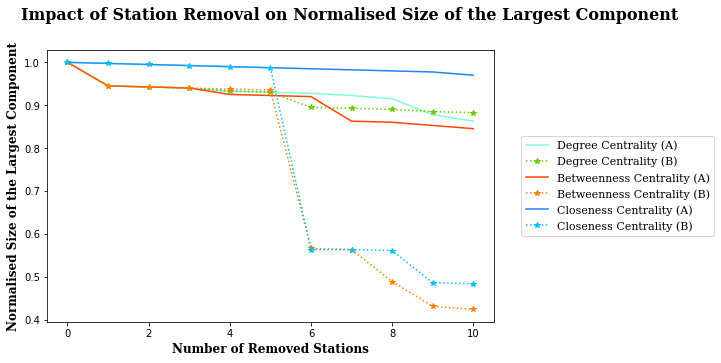

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = df_degree_A.index.values
y1 = df_degree_A['Normalised Size (A)']
y2 = df_degree_B['Normalised Size (B)']
y3 = df_bet_A['Normalised Size (A)']
y4 = df_bet_B['Normalised Size (B)']
y5 = df_clos_A['Normalised Size (A)']
y6 = df_clos_B['Normalised Size (B)']

# Plot the data
fig, ax = plt.subplots(figsize=(8, 5))  # set the figure size here
ax.plot(x, y1, label="Degree Centrality (A)", color = '#7FFFD4')
ax.plot(x, y2, label="Degree Centrality (B)", linestyle = ':', color = '#66CD00', marker='*')
ax.plot(x, y3, label="Betweenness Centrality (A)", color = "#FF4500")
ax.plot(x, y4, label="Betweenness Centrality (B)", linestyle = ':', color = '#FF8000', marker='*')
ax.plot(x, y5, label="Closeness Centrality (A)", color = '#1C86EE')
ax.plot(x, y6, label="Closeness Centrality (B)", linestyle = ':', color = '#00BFFF',marker='*')

# Move the legend to the right-hand side and set font
ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', prop={'family': 'Serif', 'size': 11})


# Add labels and title
ax.set_xlabel("Number of Removed Stations", font='Serif', fontsize = 12, fontweight='bold')
ax.set_ylabel("Normalised Size of the Largest Component", font='Serif', fontsize = 12, fontweight='bold')
plt.suptitle("Impact of Station Removal on Normalised Size of the Largest Component", fontsize=16, font='Serif',  fontweight='bold', x=0.65, y=1)


# Show the plot
#plt.show()
# save figure
plt.savefig('figure1.png',dpi=300, bbox_inches = "tight")

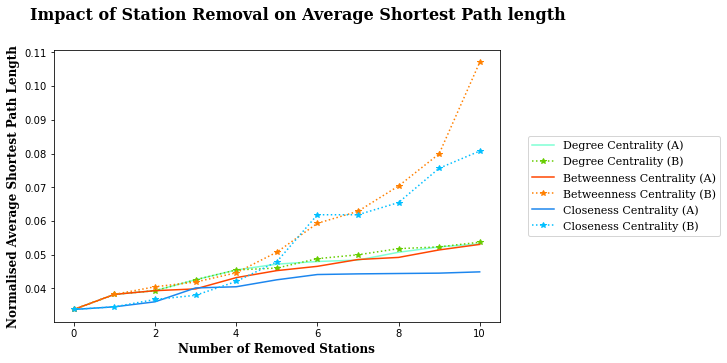

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = df_degree_A.index.values
y1 = df_degree_A['Normalised Average Shortest Path (A)']
y2 = df_degree_B['Normalised Average Shortest Path (B)']
y3 = df_bet_A['Normalised Average Shortest Path (A)']
y4 = df_bet_B['Normalised Average Shortest Path (B)']
y5 = df_clos_A['Normalised Average Shortest Path (A)']
y6 = df_clos_B['Normalised Average Shortest Path (B)']

# Plot the data
fig, ax = plt.subplots(figsize=(8, 5))  # set the figure size here
ax.plot(x, y1, label="Degree Centrality (A)", color ='#7FFFD4')
ax.plot(x, y2, label="Degree Centrality (B)", linestyle = ':', color = '#66CD00', marker='*')
ax.plot(x, y3, label="Betweenness Centrality (A)", color = "#FF4500")
ax.plot(x, y4, label="Betweenness Centrality (B)", linestyle = ':', color = '#FF8000', marker='*')
ax.plot(x, y5, label="Closeness Centrality (A)",color = '#1C86EE')
ax.plot(x, y6, label="Closeness Centrality (B)", linestyle = ':', color = '#00BFFF',marker='*')

# Move the legend to the right-hand side and set font
ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', prop={'family': 'Serif', 'size': 11})


# Add labels and title
ax.set_xlabel("Number of Removed Stations", font='Serif', fontsize = 12, fontweight='bold')
ax.set_ylabel("Normalised Average Shortest Path Length", font='Serif', fontsize = 12, fontweight='bold')
plt.suptitle("Impact of Station Removal on Average Shortest Path length", fontsize=16, font='Serif',  fontweight='bold', x=0.55, y=1)

# Show the plot
#plt.show()
# save figure
plt.savefig('figure2.png', dpi=300, bbox_inches = "tight")

- which centrality measure reflects better the importance of a station for the functioning of the underground, 
- which strategy is more effective at studying resilience, 
- which impact measure is better at assessing the damage after node removal. 

## 2. Weighted Networks

### 2.1. Weighted Betweenness Centrality

In [36]:
G4 = G.copy()

# check edge attributes
print(list(G4.edges(data = True))[0])
# check node attributes
print(list(G4.nodes(data=True))[0])
# check number of initial nodes
print(len(list(G4.nodes(data = True))))

('Waterloo', 'Bank and Monument', {'length': 2542.954443856927, 'line_name': 'Waterloo & City', 'flows': 255934})
('Waterloo', {'coords': (530974.0910233686, 179921.09873829264), 'degree': 0.015, 'closeness_t': 0.11226494527083918, 'betweeness_t': 19464.882323232356})
401


In [37]:
# filter "0" flow stations
filtered = pd.DataFrame(index=G4.edges())
filtered["flows"] = pd.Series(nx.get_edge_attributes(G4, "flows"))
filtered

# filter stationis with the least top 10 flows
filtered = filtered.sort_values(["flows"], ascending=True)
filtered[0:10]

# Battersea Park, Battersea Power Station and Nine Elms opened in 2021

,,flows
Kennington,Nine Elms,0
Wandsworth Road,Battersea Park,0
Battersea Power Station,Nine Elms,0
Elephant & Castle,Lambeth North,94
Theobalds Grove,Cheshunt,287
Heathrow Terminal 4,Heathrow Terminals 2 & 3,310
Star Lane,Canning Town,452
Hainault,Grange Hill,504
West Kensington,Barons Court,864
Turkey Street,Theobalds Grove,934


In [38]:
# remove nodes
G4.remove_nodes_from(["Nine Elms", "Battersea Park", "Battersea Power Station"])

# number of nodes after the removal
print(len(list(G4.nodes)))

398


In [39]:
# flows indicate high connection between two stations
# therefore, we need to invert weight
inv_weights = {(e1, e2): round(1.0 / weight, 7) for e1, e2, weight in G4.edges(data="flows")}

# Let us add the inversed weight as an attribute to the edges in the graph
nx.set_edge_attributes(G4, inv_weights, 'inv_weights')

In [40]:
# Lets compute weighted betweenness centrality
bet_london_w = nx.betweenness_centrality(G4, weight="inv_weights", normalized = False)

# We can add these values to the nodes attributes:
nx.set_node_attributes(G4, bet_london_w, "inv_betweenness_w")

In [41]:
df_bet_w = pd.DataFrame.from_dict(bet_london_w, columns=["Weighted Betweenness Centrality"], orient="index")

# 10 highest stations with weighted betweenness centrality
df_bet_w = df_bet_w.sort_values(["Weighted Betweenness Centrality"], ascending=False)
df_bet_w[0:10]

,Weighted Betweenness Centrality
Green Park,45419.25
Bank and Monument,35945.50
Waterloo,29612.50
Westminster,27866.50
Liverpool Street,26872.00
Stratford,26416.00
Euston,22442.50
Victoria,21573.75
Oxford Circus,21523.50
Warren Street,20002.00


### 2.2. Measuring Impacts

- II.2. Now consider the measure for assessing the impact of node removal. Would you adjust the 
measure for a weighted network? If yes, how? Propose a different measure that would be better at 
assessing the impact of closing a station taking into consideration the passengers.

In topological networks, we used the number of components and average shortest path to assess the impacts of station shut down.

__Topological Betweenness Centrality__: This is a measure of the number of **shortest paths** between all pairs of 
nodes passing though that vertex. If we do not specify weight, all edge weight are considered equal. This will enable us to see which nodes (who) are most likely to be passed.

In tube network, where nodes represent tube stations, links exist if tubes pass between them, and the weights of the links represent the passenger's flow. Higher flow can indicate a more significant demand for travel between the two stations or a more efficient route, resulting in more passengers choosing that particular route. The weights of the links can be used to determine which routes are most frequently used and which stations have the most significant passenger flow.


Perhaps we can measure the impacts of node removals by using average clustering coefficients and average shortest path?

Weighted betweenness centrality calculates the number of shortest paths between all pairs of nodes that pass through a given node, and sums up the weights of the edges on those paths. Nodes with high weighted betweenness centrality are important because they lie on many of the shortest paths between other nodes in the network, and are thus critical to the flow of information or resources through the network. In a tube network where weights represent passenger flow, tube stations with high weighted betweenness centrality indicate the importance of the stations in terms of **facilitating passenger movement** through the network. These stations act as **key connectors** between different parts of the network, and their closure or disruption could have a significant impact on the overall passenger flow and network efficiency. 

The clustering coefficient of a node is a measure of the proportion of its neighbors that are also neighbors of each other. If a tube station with high passenger's flow shuts down, this would likely to disrupt the tube system as the tube station with high weighted betweenness centrality is like a connecting point of other tube stations.

Likewise, average shortest path would also increase as this closed tube station is like a tube station that lies on the shortest path on which lots of trains passing through to get to their destination. 

### 2.3. Three nodes removal 

II.3. Remove only the 3 highest ranked nodes according to the best performing centrality measure found in I.1 - Topological Betweenness Centrality 

Evaluate the impact according to the 2 measures in II.2 - Average Clustering Coefficient and Average Shortest Path 

Repeat the experiment for the highest 3 ranked nodes using the adjusted measure - Weighted Betweenness Centrality.

Critically discuss which station closure will have the largest impact on passengers, referring to your measures and results.


In [42]:
# calculate average clustering coefficient and average shortest path
G5 = G4.copy()

# average clustering coefficient
avg_clus_coef_o = nx.average_clustering(G5, weight="inv_weights")
print(f"The initial average clustering coefficient is {avg_clus_coef_o}")

# average shortest path
avg_sh_path_len_o = nx.average_shortest_path_length(G5, weight="inv_weights")
print(f"The initial average shortest path length is {avg_sh_path_len_o}")

# travel efficiency
travel_eff_o = 1/ avg_sh_path_len_o
print(f"The travel efficiency is {travel_eff_o}")

The initial average clustering coefficient is 0.0006836388531501695
The initial average shortest path length is 0.0008079919610647748
The travel efficiency is 1237.636075836938


#### 2.3.1 Top 3 topological betweenness centrality tube stations

In [43]:
t_betweenness_df.head(3)

,Topological Betweenness Centrality
Stratford,23768.093434
Bank and Monument,23181.058947
Liverpool Street,21610.387049


**Case 1 - Top 3 tube stations with high topological betweenness centrality**

Impacts assessed by average clustering coefficient and average shortest path

In [44]:
# empty lists
short_path = []
avg_clust = []
station_removed = []
travel_eff_w = []

G6 = G4.copy()

# original network attributes
station_removed.append("Original")
avg_clust.append(avg_clus_coef_o)
short_path.append(avg_sh_path_len_o)
travel_eff_w.append(travel_eff_o)

for j in range(0, 3):

    # extract the degree values from each of prev calcluated degrees, pick the max
    bet_values = [(i[1]["betweeness_t"]) for i in G6.nodes(data=True)]
    maxdeg = [
        n for n in G6.nodes() if G6.nodes[n]["betweeness_t"] == max(bet_values)
    ]
    #print(maxdeg)
    # append to list of stations removed
    station_removed.append(maxdeg[0])

    # remove node:
    G6.remove_nodes_from([maxdeg[0]])
    # number of nodes after the removal
    #print(len(list(G6.nodes)))

    # recalculate the betweeness centrality using networkx function:
    bet_cen_new = nx.betweenness_centrality(G6)
    nx.set_node_attributes(G6, dict(bet_cen_new), "betweeness_t")

    # calculate average clustering coefficient
    avg_cluster_coef = nx.average_clustering(G6, weight="inv_weights")
    # append to list
    avg_clust.append(avg_cluster_coef)
    
    # calculate the number of components
    num_components = nx.connected_components(G6)

    largest_component = max(num_components, key=len)
    
    # Create a "subgraph" of the largest component
    largest_subgraph = G6.subgraph(largest_component)
    
    # average_shortest_path_length for the largest component
    avg_short_path = nx.average_shortest_path_length(largest_subgraph, weight="inv_weights")
   
    short_path.append(avg_short_path)
    
    # Weighted travel efficiency
    travel_efficiency_w = 1 / avg_short_path
    travel_eff_w.append(travel_efficiency_w)

    #     global_efficiency=nx.global_efficiency(largest_subgraph)
    #     global_efficiency_list.append(global_efficiency)
    
    
# Create a dictionary of results
results_dict = {
    "Station Removed (T)": station_removed,
    "Average Clustering Coefficient (T)": avg_clust,
    "Average Shortest Path Length (T)": short_path,
    "Weighted Travel Efficiency (T)": travel_eff_w
}

# Create a Pandas dataframe from the dictionary
results_df_1 = pd.DataFrame(results_dict)

# Print the dataframe
results_df_1

,Station Removed (T),Average Clustering Coefficient (T),Average Shortest Path Length (T),Weighted Travel Efficiency (T)
0,Original,0.000684,0.000808,1237.636076
1,Stratford,0.000688,0.001095,913.635582
2,King's Cross St. Pancras,0.000692,0.001233,811.163642
3,Waterloo,0.000692,0.001367,731.369948


**Case 2 - Top 3 tube stations with high weighted betweenness centrality**

Impacts assessed by average clustering coefficient and average shortest path

In [45]:
# empty lists
short_path = []
avg_clust = []
station_removed = []
travel_eff_w = []

G7 = G4.copy()

# original network attributes
station_removed.append("Original")
avg_clust.append(avg_clus_coef_o)
short_path.append(avg_sh_path_len_o)
travel_eff_w.append(travel_eff_o)


# node removal process
for j in range(0, 3):

    # extract the degree values from each of prev calcluated degrees, pick the max
    bet_values = [(i[1]["inv_betweenness_w"]) for i in G7.nodes(data=True)]
    maxdeg = [
        n for n in G7.nodes() if G7.nodes[n]["inv_betweenness_w"] == max(bet_values)
    ]
    #print(maxdeg)
    # append to list of stations removed
    station_removed.append(maxdeg[0])

    # remove node:
    G7.remove_nodes_from([maxdeg[0]])
    # number of nodes after the removal
    #print(len(list(G7.nodes)))

    # recalculate the degree centrality using networkx function:
    bet_cen_new = nx.betweenness_centrality(G7, weight = "inv_weights")
    nx.set_node_attributes(G7, dict(bet_cen_new), "inv_betweenness_w")

    # calculate no of components
    clust = nx.average_clustering(G7, weight="inv_weights")
    # append to list
    avg_clust.append(clust)
    

    components = nx.connected_components(G7)
    # print(f"Number of components {No_components}")
    # Use the max() command to find the largest one:
    largest_component = max(components, key=len)
    # Create a "subgraph" of the largest component
    largest_subgraph = G7.subgraph(largest_component)
    
    # average_shortest_path_length for the largest component
    Sh_path = nx.average_shortest_path_length(largest_subgraph, weight="inv_weights")

    short_path.append(Sh_path)
    

    global_eff_w = 1 / Sh_path
    travel_eff_w.append(global_eff_w)
 
    
# Create a dictionary of results
results_dict1 = {
    "Station Removed (W)": station_removed,
    "Average Clustering Coefficient (W)": avg_clust,
    "Average Shortest Path Length (W)": short_path,
    "Weighted Travel Efficiency (W)": travel_eff_w
}

# Create a Pandas dataframe from the dictionary
results_df_2 = pd.DataFrame(results_dict1)

# Print the dataframe
results_df_2

,Station Removed (W),Average Clustering Coefficient (W),Average Shortest Path Length (W),Weighted Travel Efficiency (W)
0,Original,0.000684,0.000808,1237.636076
1,Green Park,0.000687,0.000842,1187.436302
2,King's Cross St. Pancras,0.000691,0.000978,1022.937242
3,Bank and Monument,0.000692,0.001152,867.927752


In [46]:
# Case 2 - bank and monument 랑 waterloo 값 다름
#     # recalculate the degree centrality using networkx function:
    #bet_cen_new = nx.betweenness_centrality(Ge_w), 이거 계산할 때 다시 inv_weights를 weight로 넣어야 하지 않나??
    #nx.set_node_attributes(Ge_w, dict(bet_cen_new), "inv_betweenness_w")
    
# average clusterin gocefficient가 늘어나는데 감소해야되지 않나??

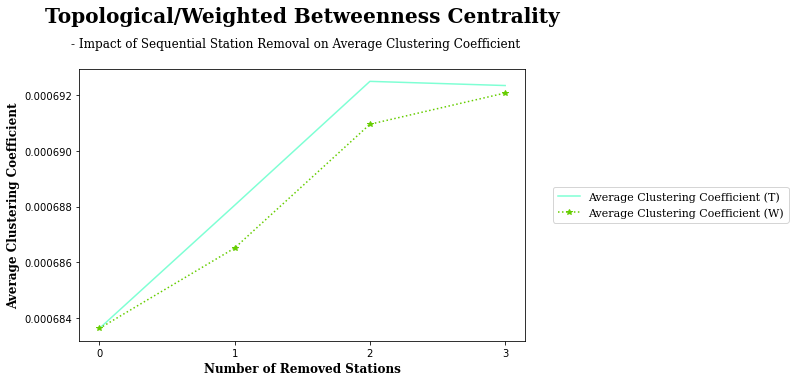

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = results_df_1.index.values
y1 = results_df_1['Average Clustering Coefficient (T)']
y2 = results_df_2['Average Clustering Coefficient (W)']



# Plot the data
fig, ax = plt.subplots(figsize=(8, 5))  # set the figure size here
ax.plot(x, y1, label="Average Clustering Coefficient (T)", color = '#7FFFD4')
ax.plot(x, y2, label='Average Clustering Coefficient (W)', linestyle = ':', color = '#66CD00', marker='*')

# Set the x-ticks interval to 1
ax.set_xticks(np.arange(min(x), max(x)+1, 1))

# Move the legend to the right-hand side and set font
ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', prop={'family': 'Serif', 'size': 11})


# Add labels and title
ax.set_xlabel("Number of Removed Stations", font='Serif', fontsize = 12, fontweight='bold')
ax.set_ylabel("Average Clustering Coefficient", font='Serif', fontsize = 12, fontweight='bold')
plt.suptitle("- Impact of Sequential Station Removal on Average Clustering Coefficient", fontsize=12, font='Serif', x=0.5, y=0.97)
plt.title("Topological/Weighted Betweenness Centrality", fontsize=20, fontweight='bold', font='Serif', y=1.15)

# Show the plot
#plt.show()
plt.savefig('fig3.png', dpi=300, bbox_inches = "tight")

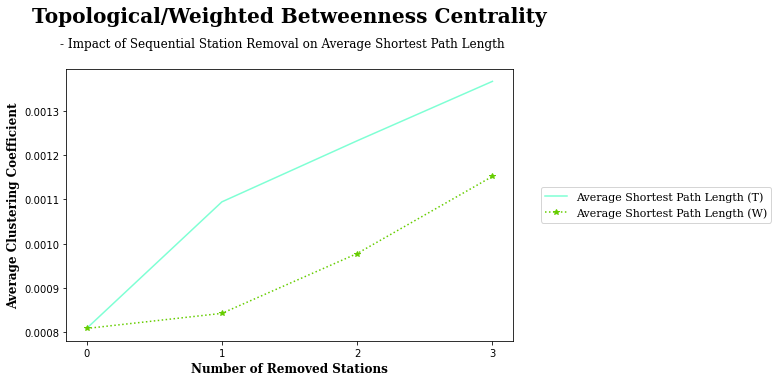

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = results_df_1.index.values
y1 = results_df_1["Average Shortest Path Length (T)"]
y2 = results_df_2["Average Shortest Path Length (W)"]


# Plot the data
fig, ax = plt.subplots(figsize=(8, 5))  # set the figure size here
ax.plot(x, y1, label="Average Shortest Path Length (T)", color = '#7FFFD4')
ax.plot(x, y2, label="Average Shortest Path Length (W)", linestyle = ':', color = '#66CD00', marker='*')

# Set the x-ticks interval to 1
ax.set_xticks(np.arange(min(x), max(x)+1, 1))

# Move the legend to the right-hand side and set font
ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', prop={'family': 'Serif', 'size': 11})


# Add labels and title
ax.set_xlabel("Number of Removed Stations", font='Serif', fontsize = 12, fontweight='bold')
ax.set_ylabel("Average Clustering Coefficient", font='Serif', fontsize = 12, fontweight='bold')
plt.suptitle("- Impact of Sequential Station Removal on Average Shortest Path Length", fontsize=12, font='Serif', x=0.5, y=0.97)
plt.title("Topological/Weighted Betweenness Centrality", fontsize=20, fontweight='bold', font='Serif', y=1.15)

# Show the plot
#plt.show()
plt.savefig('fig4.png', dpi=300, bbox_inches = "tight")

## 3. Spatial Interaction Models

### 3.1. Models and Calibration

Briefly introduce the spatial interaction models covered in the lectures using equations and 
defining the terms, taking particular care in explaining the role of the parameters.

The spatial interaction models are derived from the Newton's gravitational model.

\begin{equation} \tag{1}
T_{ij} = k \frac{O_i^\alpha  D_j^\gamma}{ d_{ij}^\beta}
\end{equation}


which can be written in the form more familiar from [Wilson's 1971 paper](http://journals.sagepub.com/doi/abs/10.1068/a030001) 

\begin{equation} \tag{2}
T_{ij} = k O_i^\alpha  D_j^\gamma  d_{ij}^{-\beta}
\end{equation}

O is emissiveness of origins, D is attractiveness of all destinations, while d is costs regarding the flows between i and j. 
As origin and destination masses increase, flows increase, but as distance increases, flows decrease, and vice versa.</b>

- **Unconstrained model**: The unconstrained model is a basic model which gave rise to other spatial interaction models. k is the parameter which ensures the model to meet the total number of trips add upto the observed number of trips. 

- **Production-constrained model**: If flow estimates from each origin zone i is known, we can constrain this information and predict where people will locate at the destination. This type of model is useful for evaluating the impact of changes in the attractiveness of destinations, such as the opening of a new shopping center. In the production-constrained model, 𝑂𝑖 does not have a parameter as it is a known constraint. 𝐴𝑖 is known as a balancing factor which ensures flow estimates from each origin sum to the known totals, 𝑂𝑖. It lets us to predict the amount of activity attracted to destination. Based on the information of origin, we can know how the flows originated from origin will be distributed in the destination. 

- **Destination-constrained model**: We have constraints on the destination here. bj is a balancing factor which is the destination parameter that makes sure the destination is met. The model uses this parameter to ensure that the total number of trips attracted to a destination zone does not exceed its capacity. In this model, it is assumed that the destinations have limited capacity to accommodate the incoming flow. The model aims to allocate the incoming flow to the available capacity of each destination while minimizing the total transportation cost. This model can help in understanding where the flows are drawn from. Based on the information of destination, we can predict the flows drawn from origin to the destination.

- **Doubly-constrained model**: If we constrain our model estimates to known information at origin and destination, we can examine how distribution of traffic flow patterns are different from model and observe the change in model parameters.
 

In [49]:
# set up the metric calculations
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""

    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r ** 2

    return R2


def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""

    res = (observed - estimated) ** 2
    RMSE = round(sqrt(res.mean()), 3)

    return RMSE

In [50]:
london_flows = pd.read_csv('london_flows.csv')
london_flows.head(n=3)

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872


In [51]:
london_flows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61474 entries, 0 to 61473
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61474 non-null  object 
 1   station_destination  61474 non-null  object 
 2   flows                61474 non-null  int64  
 3   population           61474 non-null  int64  
 4   jobs                 61474 non-null  int64  
 5   distance             61474 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.8+ MB


In [52]:
# pivot table of london flow data
pivot_london_flows = pd.pivot_table(london_flows, values="flows", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)

pd.set_option("display.max_columns", None)

pivot_london_flows

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,Archway,Arnos Grove,Arsenal,Baker Street,Balham,Bank and Monument,Barbican,Barking,Barkingside,Barons Court,Battersea Park,Bayswater,Beckton,Beckton Park,Becontree,Belsize Park,Bermondsey,Bethnal Green,Blackfriars,Blackhorse Road,Blackwall,Bond Street,Borough,Boston Manor,Bounds Green,Bow Church,Bow Road,Brent Cross,Brentwood,Brixton,Brockley,Bromley-by-Bow,Brondesbury,Brondesbury Park,Bruce Grove,Buckhurst Hill,Burnt Oak,Bush Hill Park,Bushey,Caledonian Road,Caledonian Road & Barnsbury,Cambridge Heath,Camden Road,Camden Town,Canada Water,Canary Wharf,Canning Town,Cannon Street,Canonbury,Canons Park,Carpenders Park,Chadwell Heath,Chalfont & Latimer,Chalk Farm,Chancery Lane,Charing Cross,Chesham,Cheshunt,Chigwell,Chingford,Chiswick Park,Chorleywood,Clapham Common,Clapham High Street,Clapham Junction,Clapham North,Clapham South,Clapton,Cockfosters,Colindale,Colliers Wood,Covent Garden,Crossharbour,Crouch Hill,Croxley,Crystal Palace,Custom House,Cutty Sark,Cyprus,Dagenham East,Dagenham Heathway,Dalston Junction,Dalston Kingsland,Debden,Denmark Hill,Deptford Bridge,Devons Road,Dollis Hill,Ealing Broadway,Ealing Common,Earl's Court,East Acton,East Finchley,East Ham,East India,East Putney,Eastcote,Edgware,Edgware Road,Edmonton Green,Elephant & Castle,Elm Park,Elverson Road,Embankment,Emerson Park,Enfield Town,Epping,Euston,Euston Square,Fairlop,Farringdon,Finchley Central,Finchley Road,Finchley Road & Frognal,Finsbury Park,Forest Gate,Forest Hill,Fulham Broadway,Gallions Reach,Gants Hill,Gidea Park,Gloucester Road,Golders Green,Goldhawk Road,Goodge Street,Goodmayes,Gospel Oak,Grange Hill,Great Portland Street,Green Park,Greenford,Greenwich,Gunnersbury,Hackney Central,Hackney Downs,Hackney Wick,Haggerston,Hainault,Hammersmith,Hampstead,Hampstead Heath,Hanger Lane,Harlesden,Harold Wood,Harringay Green Lanes,Harrow & Wealdstone,Harrow-on-the-Hill,Hatch End,Hatton Cross,Headstone Lane,Heathrow Terminal 4,Heathrow Terminal 5,Heathrow Terminals 2 & 3,Hendon Central,Heron Quays,High Barnet,High Street Kensington,Highams Park,Highbury & Islington,Highgate,Hillingdon,Holborn,Holland Park,Holloway Road,Homerton,Honor Oak Park,Hornchurch,Hounslow Central,Hounslow East,Hounslow West,Hoxton,Hyde Park Corner,Ickenham,Ilford,Imperial Wharf,Island Gardens,Kennington,Kensal Green,Kensal Rise,Kensington,Kentish Town,Kentish Town West,Kenton,Kew Gardens,Kilburn,Kilburn High Road,Kilburn Park,King George V,King's Cross St. Pancras,Kingsbury,Knightsbridge,Ladbroke Grove,Lambeth North,Lancaster Gate,Langdon Park,Latimer Road,Leicester Square,Lewisham,Leyton,Leyton Midland Road,Leytonstone,Leytonstone High Road,Limehouse,Liverpool Street,London Bridge,London City Airport,London Fields,Loughton,Maida Vale,Manor House,Manor Park,Mansion House,Marble Arch,Maryland,Marylebone,Mile End,Mill Hill East,Moor Park,Moorgate,Morden,Mornington Crescent,Mudchute,Neasden,New Cross,New Cross Gate,Newbury Park,North Acton,North Ealing,North Greenwich,North Harrow,North Wembley,Northfields,Northolt,Northwick Park,Northwood,Northwood Hills,Norwood Junction,Notting Hill Gate,Oakwood,Old Street,Osterley,Oval,Oxford Circus,Paddington,Park Royal,Parsons Green,Peckham Rye,Penge West,Perivale,Piccadilly Circus,Pimlico,Pinner,Plaistow,Pontoon Dock,Poplar,Preston Road,Prince Regent,Pudding Mill Lane,Putney Bridge,Queen's Park,Queens Road Peckham,Queensbury,Queensway,Ravenscourt Park,Rayners Lane,Rectory Road,Redbridge,Regent's Park,Richmond,Rickmansworth,Roding Valley,Romford,Rotherhithe,Royal Albert,Royal Oak,Royal Victoria,Ruislip,Ruislip Gardens,Ruislip Manor,Russell Square,Seven Kings,Seven Sisters,Shadwell,Shenfield,Shepherd's Bush,Shepherd's Bush Market,Shoreditch High Street,Silver Street,Sloane Square,Snaresbrook,South Acton,South Ealing,South Hampstead,South Harrow,South Kensington,South Kenton,South Quay,South Ruislip,South Tottenham,South Wimbledon,Sou

### 3.2. Calibration of Parameters

Using the information of population, jobs and flows, select a spatial interaction model and calibrate the parameter for the cost function (usually denoted as ). It is essential that you justify the model selected.

Doubly Constrained model

**Remove 0 values**

Remove Battersea Park as logarithm cannot be taken on 0 values. The Battersea Park station has opened after the data collection so its values are typed as 0.

In [53]:
london_flows[london_flows["station_origin"] == "Battersea Park"]

,station_origin,station_destination,flows,population,jobs,distance
3795,Battersea Park,Brockley,0,0,468,13201.698809
3796,Battersea Park,Canada Water,0,0,20443,10440.366798
3797,Battersea Park,Clapham High Street,0,0,1296,1790.459591
3798,Battersea Park,Dalston Junction,0,0,1289,17192.960480
3799,Battersea Park,Denmark Hill,0,0,2612,5032.444704
3800,Battersea Park,Forest Hill,0,0,608,16194.083957
3801,Battersea Park,Hackney Central,0,0,2440,21027.763711
3802,Battersea Park,Haggerston,0,0,1184,16384.952185
3803,Battersea Park,Homerton,0,0,1998,21110.011316
3804,Battersea Park,Honor Oak Park,0,0,341,14936.019983


In [54]:
# origin, destination = Battersea Park

london_flows.drop(london_flows[london_flows["station_origin"] == "Battersea Park"].index, inplace=True)
london_flows.drop(london_flows[london_flows["station_destination"] == "Battersea Park"].index, inplace=True)

In [55]:
# Battersea Park dropped
print(len(london_flows[london_flows["station_origin"] == "Battersea Park"]))
print(len(london_flows[london_flows["station_destination"] == "Battersea Park"]))

0
0


In [56]:
# drop distance = 0 
london_flows.drop(london_flows[london_flows["distance"] == 0].index, inplace=True)
print(len(london_flows[london_flows["distance"] == 0]))

0


In [57]:
# 64 rows have been dropped
london_flows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61413 entries, 0 to 61473
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61413 non-null  object 
 1   station_destination  61413 non-null  object 
 2   flows                61413 non-null  int64  
 3   population           61413 non-null  int64  
 4   jobs                 61413 non-null  int64  
 5   distance             61413 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 3.3+ MB


**Logarithm**

For Poisson Regression equation.

In [58]:
# take the variables and produce logarithms of them
x_variables = ["population", "jobs", "distance"]
log_x_vars = []
for x in x_variables:
    london_flows[f"log_{x}"] = np.log(london_flows[x])
    log_x_vars.append(f"log_{x}")

#### 3.2.1. Doubly-constrained with inverse power law

In [59]:
# Run a doubly constrained SIM with an inverse power law cost function.
doubsim_form = "flows ~ station_destination + station_origin + log_distance-1"

# run the regression for doubly
doubSim = smf.glm(formula=doubsim_form, data=london_flows, family=sm.families.Poisson()).fit()
# let's have a look at it's summary
#print(doubSim.summary())

In [60]:
beta = -doubSim.params[-1]
beta

0.9090637731839025

In [61]:
# store flow estimates to original data
london_flows["doubsim_pow"] = np.round(doubSim.mu)

# here's the matrix (pivot table). shows estimate flows of origin and destination
london_flows_pivot_dc = london_flows.pivot_table(values="doubsim_pow", index="station_origin", columns="station_destination", 
                                                 aggfunc=np.sum, margins=True)


pd.set_option("display.max_columns", None)


london_flows_pivot_dc

# see how the orig and dest constraines almost hold

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,Archway,Arnos Grove,Arsenal,Baker Street,Balham,Bank and Monument,Barbican,Barking,Barkingside,Barons Court,Bayswater,Beckton,Beckton Park,Becontree,Belsize Park,Bermondsey,Bethnal Green,Blackfriars,Blackhorse Road,Blackwall,Bond Street,Borough,Boston Manor,Bounds Green,Bow Church,Bow Road,Brent Cross,Brentwood,Brixton,Brockley,Bromley-by-Bow,Brondesbury,Brondesbury Park,Bruce Grove,Buckhurst Hill,Burnt Oak,Bush Hill Park,Bushey,Caledonian Road,Caledonian Road & Barnsbury,Cambridge Heath,Camden Road,Camden Town,Canada Water,Canary Wharf,Canning Town,Cannon Street,Canonbury,Canons Park,Carpenders Park,Chadwell Heath,Chalfont & Latimer,Chalk Farm,Chancery Lane,Charing Cross,Chesham,Cheshunt,Chigwell,Chingford,Chiswick Park,Chorleywood,Clapham Common,Clapham High Street,Clapham Junction,Clapham North,Clapham South,Clapton,Cockfosters,Colindale,Colliers Wood,Covent Garden,Crossharbour,Crouch Hill,Croxley,Crystal Palace,Custom House,Cutty Sark,Cyprus,Dagenham East,Dagenham Heathway,Dalston Junction,Dalston Kingsland,Debden,Denmark Hill,Deptford Bridge,Devons Road,Dollis Hill,Ealing Broadway,Ealing Common,Earl's Court,East Acton,East Finchley,East Ham,East India,East Putney,Eastcote,Edgware,Edgware Road,Edmonton Green,Elephant & Castle,Elm Park,Elverson Road,Embankment,Emerson Park,Enfield Town,Epping,Euston,Euston Square,Fairlop,Farringdon,Finchley Central,Finchley Road,Finchley Road & Frognal,Finsbury Park,Forest Gate,Forest Hill,Fulham Broadway,Gallions Reach,Gants Hill,Gidea Park,Gloucester Road,Golders Green,Goldhawk Road,Goodge Street,Goodmayes,Gospel Oak,Grange Hill,Great Portland Street,Green Park,Greenford,Greenwich,Gunnersbury,Hackney Central,Hackney Downs,Hackney Wick,Haggerston,Hainault,Hammersmith,Hampstead,Hampstead Heath,Hanger Lane,Harlesden,Harold Wood,Harringay Green Lanes,Harrow & Wealdstone,Harrow-on-the-Hill,Hatch End,Hatton Cross,Headstone Lane,Heathrow Terminal 4,Heathrow Terminal 5,Heathrow Terminals 2 & 3,Hendon Central,Heron Quays,High Barnet,High Street Kensington,Highams Park,Highbury & Islington,Highgate,Hillingdon,Holborn,Holland Park,Holloway Road,Homerton,Honor Oak Park,Hornchurch,Hounslow Central,Hounslow East,Hounslow West,Hoxton,Hyde Park Corner,Ickenham,Ilford,Imperial Wharf,Island Gardens,Kennington,Kensal Green,Kensal Rise,Kensington,Kentish Town,Kentish Town West,Kenton,Kew Gardens,Kilburn,Kilburn High Road,Kilburn Park,King George V,King's Cross St. Pancras,Kingsbury,Knightsbridge,Ladbroke Grove,Lambeth North,Lancaster Gate,Langdon Park,Latimer Road,Leicester Square,Lewisham,Leyton,Leyton Midland Road,Leytonstone,Leytonstone High Road,Limehouse,Liverpool Street,London Bridge,London City Airport,London Fields,Loughton,Maida Vale,Manor House,Manor Park,Mansion House,Marble Arch,Maryland,Marylebone,Mile End,Mill Hill East,Moor Park,Moorgate,Morden,Mornington Crescent,Mudchute,Neasden,New Cross,New Cross Gate,Newbury Park,North Acton,North Ealing,North Greenwich,North Harrow,North Wembley,Northfields,Northolt,Northwick Park,Northwood,Northwood Hills,Norwood Junction,Notting Hill Gate,Oakwood,Old Street,Osterley,Oval,Oxford Circus,Paddington,Park Royal,Parsons Green,Peckham Rye,Penge West,Perivale,Piccadilly Circus,Pimlico,Pinner,Plaistow,Pontoon Dock,Poplar,Preston Road,Prince Regent,Pudding Mill Lane,Putney Bridge,Queen's Park,Queens Road Peckham,Queensbury,Queensway,Ravenscourt Park,Rayners Lane,Rectory Road,Redbridge,Regent's Park,Richmond,Rickmansworth,Roding Valley,Romford,Rotherhithe,Royal Albert,Royal Oak,Royal Victoria,Ruislip,Ruislip Gardens,Ruislip Manor,Russell Square,Seven Kings,Seven Sisters,Shadwell,Shenfield,Shepherd's Bush,Shepherd's Bush Market,Shoreditch High Street,Silver Street,Sloane Square,Snaresbrook,South Acton,South Ealing,South Hampstead,South Harrow,South Kensington,South Kenton,South Quay,South Ruislip,South Tottenham,South Wimbledon,South Woodford,Sou

In [62]:
# R2 higher than other singly constrained models
print(f"R-squared of Negative Exponential Doubly Constrained model is {CalcRSqaured(london_flows['flows'], london_flows['doubsim_pow'])}")
print(f"RMSE of Negative Exponential Doubly Constrained model is {CalcRMSE(london_flows['flows'], london_flows['doubsim_pow'])}")

R-squared of Negative Exponential Doubly Constrained model is 0.40801008815938716
RMSE of Negative Exponential Doubly Constrained model is 101.304


#### 3.2.2. Doubly-constrained with negative exponential

In [63]:
# Run a doubly constrained SIM with negative exponential cost function.
doubsim_form_exp = "flows ~ station_destination + station_origin + distance-1"

# run the regression for doubly
doubSim_exp = smf.glm(formula = doubsim_form_exp, data = london_flows, family = sm.families.Poisson()).fit()

In [64]:
beta_exp = -doubSim_exp.params[-1]
beta_exp

0.00015401731896925091

In [65]:
# get the predicted flows to and round to whole numbers
london_flows["doubsim_exp"] = np.round(doubSim_exp.mu)

# here's the matrix (pivot table). shows estimate flows of origin and destination
london_flows_pivot_dc_exp = london_flows.pivot_table(values = "doubsim_exp", index = "station_origin", 
                                                     columns = "station_destination", aggfunc=np.sum, margins=True)
london_flows_pivot_dc_exp

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,Archway,Arnos Grove,Arsenal,Baker Street,Balham,Bank and Monument,Barbican,Barking,Barkingside,Barons Court,Bayswater,Beckton,Beckton Park,Becontree,Belsize Park,Bermondsey,Bethnal Green,Blackfriars,Blackhorse Road,Blackwall,Bond Street,Borough,Boston Manor,Bounds Green,Bow Church,Bow Road,Brent Cross,Brentwood,Brixton,Brockley,Bromley-by-Bow,Brondesbury,Brondesbury Park,Bruce Grove,Buckhurst Hill,Burnt Oak,Bush Hill Park,Bushey,Caledonian Road,Caledonian Road & Barnsbury,Cambridge Heath,Camden Road,Camden Town,Canada Water,Canary Wharf,Canning Town,Cannon Street,Canonbury,Canons Park,Carpenders Park,Chadwell Heath,Chalfont & Latimer,Chalk Farm,Chancery Lane,Charing Cross,Chesham,Cheshunt,Chigwell,Chingford,Chiswick Park,Chorleywood,Clapham Common,Clapham High Street,Clapham Junction,Clapham North,Clapham South,Clapton,Cockfosters,Colindale,Colliers Wood,Covent Garden,Crossharbour,Crouch Hill,Croxley,Crystal Palace,Custom House,Cutty Sark,Cyprus,Dagenham East,Dagenham Heathway,Dalston Junction,Dalston Kingsland,Debden,Denmark Hill,Deptford Bridge,Devons Road,Dollis Hill,Ealing Broadway,Ealing Common,Earl's Court,East Acton,East Finchley,East Ham,East India,East Putney,Eastcote,Edgware,Edgware Road,Edmonton Green,Elephant & Castle,Elm Park,Elverson Road,Embankment,Emerson Park,Enfield Town,Epping,Euston,Euston Square,Fairlop,Farringdon,Finchley Central,Finchley Road,Finchley Road & Frognal,Finsbury Park,Forest Gate,Forest Hill,Fulham Broadway,Gallions Reach,Gants Hill,Gidea Park,Gloucester Road,Golders Green,Goldhawk Road,Goodge Street,Goodmayes,Gospel Oak,Grange Hill,Great Portland Street,Green Park,Greenford,Greenwich,Gunnersbury,Hackney Central,Hackney Downs,Hackney Wick,Haggerston,Hainault,Hammersmith,Hampstead,Hampstead Heath,Hanger Lane,Harlesden,Harold Wood,Harringay Green Lanes,Harrow & Wealdstone,Harrow-on-the-Hill,Hatch End,Hatton Cross,Headstone Lane,Heathrow Terminal 4,Heathrow Terminal 5,Heathrow Terminals 2 & 3,Hendon Central,Heron Quays,High Barnet,High Street Kensington,Highams Park,Highbury & Islington,Highgate,Hillingdon,Holborn,Holland Park,Holloway Road,Homerton,Honor Oak Park,Hornchurch,Hounslow Central,Hounslow East,Hounslow West,Hoxton,Hyde Park Corner,Ickenham,Ilford,Imperial Wharf,Island Gardens,Kennington,Kensal Green,Kensal Rise,Kensington,Kentish Town,Kentish Town West,Kenton,Kew Gardens,Kilburn,Kilburn High Road,Kilburn Park,King George V,King's Cross St. Pancras,Kingsbury,Knightsbridge,Ladbroke Grove,Lambeth North,Lancaster Gate,Langdon Park,Latimer Road,Leicester Square,Lewisham,Leyton,Leyton Midland Road,Leytonstone,Leytonstone High Road,Limehouse,Liverpool Street,London Bridge,London City Airport,London Fields,Loughton,Maida Vale,Manor House,Manor Park,Mansion House,Marble Arch,Maryland,Marylebone,Mile End,Mill Hill East,Moor Park,Moorgate,Morden,Mornington Crescent,Mudchute,Neasden,New Cross,New Cross Gate,Newbury Park,North Acton,North Ealing,North Greenwich,North Harrow,North Wembley,Northfields,Northolt,Northwick Park,Northwood,Northwood Hills,Norwood Junction,Notting Hill Gate,Oakwood,Old Street,Osterley,Oval,Oxford Circus,Paddington,Park Royal,Parsons Green,Peckham Rye,Penge West,Perivale,Piccadilly Circus,Pimlico,Pinner,Plaistow,Pontoon Dock,Poplar,Preston Road,Prince Regent,Pudding Mill Lane,Putney Bridge,Queen's Park,Queens Road Peckham,Queensbury,Queensway,Ravenscourt Park,Rayners Lane,Rectory Road,Redbridge,Regent's Park,Richmond,Rickmansworth,Roding Valley,Romford,Rotherhithe,Royal Albert,Royal Oak,Royal Victoria,Ruislip,Ruislip Gardens,Ruislip Manor,Russell Square,Seven Kings,Seven Sisters,Shadwell,Shenfield,Shepherd's Bush,Shepherd's Bush Market,Shoreditch High Street,Silver Street,Sloane Square,Snaresbrook,South Acton,South Ealing,South Hampstead,South Harrow,South Kensington,South Kenton,South Quay,South Ruislip,South Tottenham,South Wimbledon,South Woodford,Sou

In [66]:
# R2 higher than other singly constrained models
print(f"R-squared of Negative Exponential Doubly Constrained model is {CalcRSqaured(london_flows['flows'], london_flows['doubsim_exp'])}")
print(f"RMSE of Negative Exponential Doubly Constrained model is {CalcRMSE(london_flows['flows'], london_flows['doubsim_exp'])}")

R-squared of Negative Exponential Doubly Constrained model is 0.49766711297086647
RMSE of Negative Exponential Doubly Constrained model is 93.417


- Negative Exponential Doubly Constrained model has a higher R2 and a lower RMSE.
- This indicates that the observed interaction does not drop off rapidly with distance so we could say that the decay effect of distance in the London tube network isnt severe. 
- The observed passenger flows would not drop off rapidly with distance but rather other factors like travel fares, number or convenience or disruption of transits affect people's trip more. 

#### 3.2.3. Production-constrained with inverse power law

In [67]:
# create the formula 
formula = "flows ~ station_origin + log_jobs + log_distance-1"

prodSim = smf.glm(formula = formula, data = london_flows, family = sm.families.Poisson()).fit()

In [68]:
# coefficients from the model
alpha_i = prodSim.params[0:-2]
gamma = prodSim.params[-2]
beta = -prodSim.params[-1]

In [69]:
print(gamma)
print(beta)

0.769008492426929
0.8776286893429839


In [70]:
# flow estimates
london_flows["prodSim_pow"] = np.round(prodSim.mu)

In [71]:
# R2 and RMSE of Origin-constrained model with inverse power law
print(f"R-squared of Inverse Power Law Production Constrained model is {CalcRSqaured(london_flows['flows'], london_flows['prodSim_pow'])}")
print(f"RMSE of Inverse Power Law Production Constrained model is {CalcRMSE(london_flows['flows'], london_flows['prodSim_pow'])}")

R-squared of Inverse Power Law Production Constrained model is 0.38858831291618345
RMSE of Inverse Power Law Production Constrained model is 102.864


#### 3.2.2. Production-constrained model with negative exponential

In [72]:
# exponenetial formula with no log on distance
formula = "flows ~ station_origin + log_jobs + distance-1"

prodSim_exp = smf.glm(formula=formula, data=london_flows, family=sm.families.Poisson()).fit()

In [73]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
O_i = pd.DataFrame(london_flows.groupby(["station_origin"])["flows"].agg(np.sum))
# total flows from origin renamed as "O_i"
O_i.rename(columns={"flows": "O_i"}, inplace=True)
# merge back to original dataset
london_flows = london_flows.merge(O_i, on="station_origin", how="left")

# do the same for the destination
D_j = pd.DataFrame(london_flows.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows": "D_j"}, inplace=True)
london_flows = london_flows.merge(D_j, on="station_destination", how="left")

london_flows.head()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,doubsim_pow,doubsim_exp,prodSim_pow,O_i,D_j
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,55.0,77.0,55.0,599,78549
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,2.0,3.0,1.0,599,442
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3.0,4.0,3.0,599,665
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,77.0,112.0,67.0,599,58772
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,45.0,48.0,49.0,599,15428


In [74]:
# pull out coefficients from the model
coefs = pd.DataFrame(prodSim_exp.params)
# reset their index to have in right order
coefs.reset_index(inplace=True)
# rename columns index (the origCode) and 0 to coefficient
coefs.rename(columns={0: "alpha_i", "index": "coef"}, inplace=True)

coefs.head()

,coef,alpha_i
0,station_origin[Abbey Road],-2.918351
1,station_origin[Acton Central],-1.167164
2,station_origin[Acton Town],-1.617289
3,station_origin[Aldgate],-2.946766
4,station_origin[Aldgate East],-2.858519


In [75]:
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")

# then once you have done this you can join them back into the dataframes
# it is left join so only alpha values are added to the dataframe, not beta nor gamma
london_flows = london_flows.merge(
    coefs, left_on="station_origin", right_on="coef", how="left"
)
london_flows.drop(columns=["coef"], inplace=True)
# check this has worked
london_flows.head()

/tmp/ipykernel_753/3408313160.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,doubsim_pow,doubsim_exp,prodSim_pow,O_i,D_j,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,55.0,77.0,55.0,599,78549,-2.918351
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,2.0,3.0,1.0,599,442,-2.918351
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3.0,4.0,3.0,599,665,-2.918351
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,77.0,112.0,67.0,599,58772,-2.918351
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,45.0,48.0,49.0,599,15428,-2.918351


In [76]:
# coefficients from the model
alpha_i = prodSim_exp.params[0:-2]
gamma = prodSim_exp.params[-2]
beta = -prodSim_exp.params[-1]

In [77]:
# plug into the equation
# distance not logged as it is negative exponential
london_flows["prodSim_exp"] = np.exp(london_flows["alpha_i"] + gamma*london_flows["log_jobs"] - beta * london_flows["distance"])  
london_flows.head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,doubsim_pow,doubsim_exp,prodSim_pow,O_i,D_j,alpha_i,prodSim_exp
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,55.0,77.0,55.0,599,78549,-2.918351,77.828543
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,2.0,3.0,1.0,599,442,-2.918351,1.466714
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3.0,4.0,3.0,599,665,-2.918351,4.117462
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,77.0,112.0,67.0,599,58772,-2.918351,99.558323
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,45.0,48.0,49.0,599,15428,-2.918351,56.092669
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,3.0,5.0,3.0,599,1208,-2.918351,4.142604
6,Abbey Road,Custom House,0,599,845,3824.855630,6.395262,6.739337,8.249276,4.0,5.0,3.0,599,845,-2.918351,4.897211
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,6.395262,7.466228,9.048280,5.0,6.0,3.0,599,1748,-2.918351,4.148419
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.395262,6.745236,8.784484,4.0,5.0,2.0,599,850,-2.918351,3.252327
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.395262,6.415097,8.283576,3.0,4.0,2.0,599,611,-2.918351,3.755811


In [78]:
#first round the estimates
london_flows["prodSim_exp"] = np.round(prodSim_exp.mu, 0)

# pivot table
london_flows_pivot_pc_exp = london_flows.pivot_table(values="prodSim_exp", index="station_origin", 
                                                     columns="station_destination", aggfunc=np.sum, 
                                                     margins=True)
# london_flows_pivot_pc_exp, 1541419

In [79]:
# R2 and RMSE of Origin-constrained model with negative exponential
print(f"R-squared of Negative Exponential Production Constrained model is {CalcRSqaured(london_flows['flows'], london_flows['prodSim_exp'])}")
print(f"RMSE of Negative Exponential Production Constrained model is {CalcRMSE(london_flows['flows'], london_flows['prodSim_exp'])}")

R-squared of Negative Exponential Production Constrained model is 0.46782937904134614
RMSE of Negative Exponential Production Constrained model is 96.283


In [80]:
# Production-constrained model
beta # 0.0001528315796757068

0.0001528315796757068

## 4. Scenarios

### 4.1. Scenario A

**Canary Wharf has a 50% decrease in jobs** after Brexit. Using the calibrated parameter $beta$, compute the new flows for scenario A. Make sure the number of commuters is conserved, and explain how you ensured this.

Production-constrained model

In [81]:
# new function for Canary Wharf
def brexit(row):
    if row["station_destination"] == "Canary Wharf":
        val = 0.5 * row["jobs"]
    else:
        val = row["jobs"]
    return val

# apply the function to each row, axis = 1
london_flows["jobs_scenario"] = london_flows.apply(brexit, axis=1)
pd.set_option("display.max_columns", None)
london_flows.head()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,doubsim_pow,doubsim_exp,prodSim_pow,O_i,D_j,alpha_i,prodSim_exp,jobs_scenario
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,55.0,77.0,55.0,599,78549,-2.918351,78.0,78549.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,2.0,3.0,1.0,599,442,-2.918351,1.0,442.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3.0,4.0,3.0,599,665,-2.918351,4.0,665.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,77.0,112.0,67.0,599,58772,-2.918351,100.0,29386.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,45.0,48.0,49.0,599,15428,-2.918351,56.0,15428.0


**Recalculate alpha i**

\begin{equation} \label{eq:3} \tag{3}
A_i = \frac{1}{\sum_j D_j^\gamma d_{ij}^{-\beta}}
\end{equation}

In [82]:
# calculate dj_gamma and dist beta to calculate balancing factor Ai
Dj_gamma = london_flows["jobs_scenario"] ** gamma
dist_beta = np.exp(london_flows["distance"] * -beta)

# calcualte the first stage of the Ai values
london_flows["Ai1"] = Dj_gamma * dist_beta

# now do the sum over all js bit
A_i = pd.DataFrame(london_flows.groupby(["station_origin"])["Ai1"].agg(np.sum))
A_i.head()

,Ai1
station_origin,
Abbey Road,10336.658308
Acton Central,3932.550433
Acton Town,18800.237541
Aldgate,54362.363128
Aldgate East,54559.483888


In [83]:
# now divide into 1
A_i["A_i"] = 1 / A_i["Ai1"]
A_i.drop(['Ai1'], axis=1, inplace=True)
A_i.head()

,A_i
station_origin,
Abbey Road,0.000097
Acton Central,0.000254
Acton Town,0.000053
Aldgate,0.000018
Aldgate East,0.000018


In [84]:
# and write the A_i values back into the dataframe
london_flows = london_flows.merge(A_i, left_on="station_origin", right_index=True, how="left")

pd.set_option("display.max_columns", None)
london_flows.head()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,doubsim_pow,doubsim_exp,prodSim_pow,O_i,D_j,alpha_i,prodSim_exp,jobs_scenario,Ai1,A_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,55.0,77.0,55.0,599,78549,-2.918351,78.0,78549.0,1440.663886,0.000097
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,2.0,3.0,1.0,599,442,-2.918351,1.0,442.0,27.149959,0.000097
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3.0,4.0,3.0,599,665,-2.918351,4.0,665.0,76.217262,0.000097
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,77.0,112.0,67.0,599,58772,-2.918351,100.0,29386.0,1091.623493,0.000097
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,45.0,48.0,49.0,599,15428,-2.918351,56.0,15428.0,1038.316796,0.000097


In [85]:
# remove "Ai1" column
london_flows.drop(['Ai1'], axis=1, inplace=True)
london_flows.head()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,doubsim_pow,doubsim_exp,prodSim_pow,O_i,D_j,alpha_i,prodSim_exp,jobs_scenario,A_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,55.0,77.0,55.0,599,78549,-2.918351,78.0,78549.0,0.000097
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,2.0,3.0,1.0,599,442,-2.918351,1.0,442.0,0.000097
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3.0,4.0,3.0,599,665,-2.918351,4.0,665.0,0.000097
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,77.0,112.0,67.0,599,58772,-2.918351,100.0,29386.0,0.000097
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,45.0,48.0,49.0,599,15428,-2.918351,56.0,15428.0,0.000097


In [86]:
# plug into equation
london_flows["scenarioA_est"] = london_flows["A_i"] * london_flows["O_i"] * Dj_gamma * dist_beta

# round
london_flows["scenarioA_est"] = round(london_flows["scenarioA_est"])
london_flows["scenarioA_est"] = london_flows["scenarioA_est"].astype(int)

In [87]:
# create pivot table
prodSim_exp_scenario_A = london_flows.pivot_table(values="scenarioA_est", index="station_origin",
                                       columns="station_destination", aggfunc=np.sum, margins=True)
pd.set_option("display.max_columns", None)
prodSim_exp_scenario_A

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,Archway,Arnos Grove,Arsenal,Baker Street,Balham,Bank and Monument,Barbican,Barking,Barkingside,Barons Court,Bayswater,Beckton,Beckton Park,Becontree,Belsize Park,Bermondsey,Bethnal Green,Blackfriars,Blackhorse Road,Blackwall,Bond Street,Borough,Boston Manor,Bounds Green,Bow Church,Bow Road,Brent Cross,Brentwood,Brixton,Brockley,Bromley-by-Bow,Brondesbury,Brondesbury Park,Bruce Grove,Buckhurst Hill,Burnt Oak,Bush Hill Park,Bushey,Caledonian Road,Caledonian Road & Barnsbury,Cambridge Heath,Camden Road,Camden Town,Canada Water,Canary Wharf,Canning Town,Cannon Street,Canonbury,Canons Park,Carpenders Park,Chadwell Heath,Chalfont & Latimer,Chalk Farm,Chancery Lane,Charing Cross,Chesham,Cheshunt,Chigwell,Chingford,Chiswick Park,Chorleywood,Clapham Common,Clapham High Street,Clapham Junction,Clapham North,Clapham South,Clapton,Cockfosters,Colindale,Colliers Wood,Covent Garden,Crossharbour,Crouch Hill,Croxley,Crystal Palace,Custom House,Cutty Sark,Cyprus,Dagenham East,Dagenham Heathway,Dalston Junction,Dalston Kingsland,Debden,Denmark Hill,Deptford Bridge,Devons Road,Dollis Hill,Ealing Broadway,Ealing Common,Earl's Court,East Acton,East Finchley,East Ham,East India,East Putney,Eastcote,Edgware,Edgware Road,Edmonton Green,Elephant & Castle,Elm Park,Elverson Road,Embankment,Emerson Park,Enfield Town,Epping,Euston,Euston Square,Fairlop,Farringdon,Finchley Central,Finchley Road,Finchley Road & Frognal,Finsbury Park,Forest Gate,Forest Hill,Fulham Broadway,Gallions Reach,Gants Hill,Gidea Park,Gloucester Road,Golders Green,Goldhawk Road,Goodge Street,Goodmayes,Gospel Oak,Grange Hill,Great Portland Street,Green Park,Greenford,Greenwich,Gunnersbury,Hackney Central,Hackney Downs,Hackney Wick,Haggerston,Hainault,Hammersmith,Hampstead,Hampstead Heath,Hanger Lane,Harlesden,Harold Wood,Harringay Green Lanes,Harrow & Wealdstone,Harrow-on-the-Hill,Hatch End,Hatton Cross,Headstone Lane,Heathrow Terminal 4,Heathrow Terminal 5,Heathrow Terminals 2 & 3,Hendon Central,Heron Quays,High Barnet,High Street Kensington,Highams Park,Highbury & Islington,Highgate,Hillingdon,Holborn,Holland Park,Holloway Road,Homerton,Honor Oak Park,Hornchurch,Hounslow Central,Hounslow East,Hounslow West,Hoxton,Hyde Park Corner,Ickenham,Ilford,Imperial Wharf,Island Gardens,Kennington,Kensal Green,Kensal Rise,Kensington,Kentish Town,Kentish Town West,Kenton,Kew Gardens,Kilburn,Kilburn High Road,Kilburn Park,King George V,King's Cross St. Pancras,Kingsbury,Knightsbridge,Ladbroke Grove,Lambeth North,Lancaster Gate,Langdon Park,Latimer Road,Leicester Square,Lewisham,Leyton,Leyton Midland Road,Leytonstone,Leytonstone High Road,Limehouse,Liverpool Street,London Bridge,London City Airport,London Fields,Loughton,Maida Vale,Manor House,Manor Park,Mansion House,Marble Arch,Maryland,Marylebone,Mile End,Mill Hill East,Moor Park,Moorgate,Morden,Mornington Crescent,Mudchute,Neasden,New Cross,New Cross Gate,Newbury Park,North Acton,North Ealing,North Greenwich,North Harrow,North Wembley,Northfields,Northolt,Northwick Park,Northwood,Northwood Hills,Norwood Junction,Notting Hill Gate,Oakwood,Old Street,Osterley,Oval,Oxford Circus,Paddington,Park Royal,Parsons Green,Peckham Rye,Penge West,Perivale,Piccadilly Circus,Pimlico,Pinner,Plaistow,Pontoon Dock,Poplar,Preston Road,Prince Regent,Pudding Mill Lane,Putney Bridge,Queen's Park,Queens Road Peckham,Queensbury,Queensway,Ravenscourt Park,Rayners Lane,Rectory Road,Redbridge,Regent's Park,Richmond,Rickmansworth,Roding Valley,Romford,Rotherhithe,Royal Albert,Royal Oak,Royal Victoria,Ruislip,Ruislip Gardens,Ruislip Manor,Russell Square,Seven Kings,Seven Sisters,Shadwell,Shenfield,Shepherd's Bush,Shepherd's Bush Market,Shoreditch High Street,Silver Street,Sloane Square,Snaresbrook,South Acton,South Ealing,South Hampstead,South Harrow,South Kensington,South Kenton,South Quay,South Ruislip,South Tottenham,South Wimbledon,South Woodford,Sou

In [88]:
london_flows_pivot_pc_exp

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,Archway,Arnos Grove,Arsenal,Baker Street,Balham,Bank and Monument,Barbican,Barking,Barkingside,Barons Court,Bayswater,Beckton,Beckton Park,Becontree,Belsize Park,Bermondsey,Bethnal Green,Blackfriars,Blackhorse Road,Blackwall,Bond Street,Borough,Boston Manor,Bounds Green,Bow Church,Bow Road,Brent Cross,Brentwood,Brixton,Brockley,Bromley-by-Bow,Brondesbury,Brondesbury Park,Bruce Grove,Buckhurst Hill,Burnt Oak,Bush Hill Park,Bushey,Caledonian Road,Caledonian Road & Barnsbury,Cambridge Heath,Camden Road,Camden Town,Canada Water,Canary Wharf,Canning Town,Cannon Street,Canonbury,Canons Park,Carpenders Park,Chadwell Heath,Chalfont & Latimer,Chalk Farm,Chancery Lane,Charing Cross,Chesham,Cheshunt,Chigwell,Chingford,Chiswick Park,Chorleywood,Clapham Common,Clapham High Street,Clapham Junction,Clapham North,Clapham South,Clapton,Cockfosters,Colindale,Colliers Wood,Covent Garden,Crossharbour,Crouch Hill,Croxley,Crystal Palace,Custom House,Cutty Sark,Cyprus,Dagenham East,Dagenham Heathway,Dalston Junction,Dalston Kingsland,Debden,Denmark Hill,Deptford Bridge,Devons Road,Dollis Hill,Ealing Broadway,Ealing Common,Earl's Court,East Acton,East Finchley,East Ham,East India,East Putney,Eastcote,Edgware,Edgware Road,Edmonton Green,Elephant & Castle,Elm Park,Elverson Road,Embankment,Emerson Park,Enfield Town,Epping,Euston,Euston Square,Fairlop,Farringdon,Finchley Central,Finchley Road,Finchley Road & Frognal,Finsbury Park,Forest Gate,Forest Hill,Fulham Broadway,Gallions Reach,Gants Hill,Gidea Park,Gloucester Road,Golders Green,Goldhawk Road,Goodge Street,Goodmayes,Gospel Oak,Grange Hill,Great Portland Street,Green Park,Greenford,Greenwich,Gunnersbury,Hackney Central,Hackney Downs,Hackney Wick,Haggerston,Hainault,Hammersmith,Hampstead,Hampstead Heath,Hanger Lane,Harlesden,Harold Wood,Harringay Green Lanes,Harrow & Wealdstone,Harrow-on-the-Hill,Hatch End,Hatton Cross,Headstone Lane,Heathrow Terminal 4,Heathrow Terminal 5,Heathrow Terminals 2 & 3,Hendon Central,Heron Quays,High Barnet,High Street Kensington,Highams Park,Highbury & Islington,Highgate,Hillingdon,Holborn,Holland Park,Holloway Road,Homerton,Honor Oak Park,Hornchurch,Hounslow Central,Hounslow East,Hounslow West,Hoxton,Hyde Park Corner,Ickenham,Ilford,Imperial Wharf,Island Gardens,Kennington,Kensal Green,Kensal Rise,Kensington,Kentish Town,Kentish Town West,Kenton,Kew Gardens,Kilburn,Kilburn High Road,Kilburn Park,King George V,King's Cross St. Pancras,Kingsbury,Knightsbridge,Ladbroke Grove,Lambeth North,Lancaster Gate,Langdon Park,Latimer Road,Leicester Square,Lewisham,Leyton,Leyton Midland Road,Leytonstone,Leytonstone High Road,Limehouse,Liverpool Street,London Bridge,London City Airport,London Fields,Loughton,Maida Vale,Manor House,Manor Park,Mansion House,Marble Arch,Maryland,Marylebone,Mile End,Mill Hill East,Moor Park,Moorgate,Morden,Mornington Crescent,Mudchute,Neasden,New Cross,New Cross Gate,Newbury Park,North Acton,North Ealing,North Greenwich,North Harrow,North Wembley,Northfields,Northolt,Northwick Park,Northwood,Northwood Hills,Norwood Junction,Notting Hill Gate,Oakwood,Old Street,Osterley,Oval,Oxford Circus,Paddington,Park Royal,Parsons Green,Peckham Rye,Penge West,Perivale,Piccadilly Circus,Pimlico,Pinner,Plaistow,Pontoon Dock,Poplar,Preston Road,Prince Regent,Pudding Mill Lane,Putney Bridge,Queen's Park,Queens Road Peckham,Queensbury,Queensway,Ravenscourt Park,Rayners Lane,Rectory Road,Redbridge,Regent's Park,Richmond,Rickmansworth,Roding Valley,Romford,Rotherhithe,Royal Albert,Royal Oak,Royal Victoria,Ruislip,Ruislip Gardens,Ruislip Manor,Russell Square,Seven Kings,Seven Sisters,Shadwell,Shenfield,Shepherd's Bush,Shepherd's Bush Market,Shoreditch High Street,Silver Street,Sloane Square,Snaresbrook,South Acton,South Ealing,South Hampstead,South Harrow,South Kensington,South Kenton,South Quay,South Ruislip,South Tottenham,South Wimbledon,South Woodford,Sou

In [89]:
london_flows.head()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,doubsim_pow,doubsim_exp,prodSim_pow,O_i,D_j,alpha_i,prodSim_exp,jobs_scenario,A_i,scenarioA_est
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,55.0,77.0,55.0,599,78549,-2.918351,78.0,78549.0,0.000097,83
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,2.0,3.0,1.0,599,442,-2.918351,1.0,442.0,0.000097,2
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3.0,4.0,3.0,599,665,-2.918351,4.0,665.0,0.000097,4
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,77.0,112.0,67.0,599,58772,-2.918351,100.0,29386.0,0.000097,63
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,45.0,48.0,49.0,599,15428,-2.918351,56.0,15428.0,0.000097,60


In [90]:
flow_diff = london_flows.groupby("station_destination", as_index=False).agg(
    {"flows": "sum", "scenarioA_est": "sum"}
)
flow_diff["diff"] = flow_diff["scenarioA_est"] - flow_diff["flows"]

flow_diff.sort_values(by=["flows"], ascending=False, inplace=True)

In [91]:
len(flow_diff)
flow_diff

,station_destination,flows,scenarioA_est,diff
15,Bank and Monument,78549,70058,-8491
212,Liverpool Street,61122,59411,-1711
54,Canary Wharf,58772,29504,-29268
326,Stratford,55954,67191,11237
251,Oxford Circus,44368,39943,-4425
...,...,...,...,...
373,West Finchley,91,75,-16
22,Beckton Park,88,94,6
279,Roding Valley,84,92,8
136,Grange Hill,76,90,14


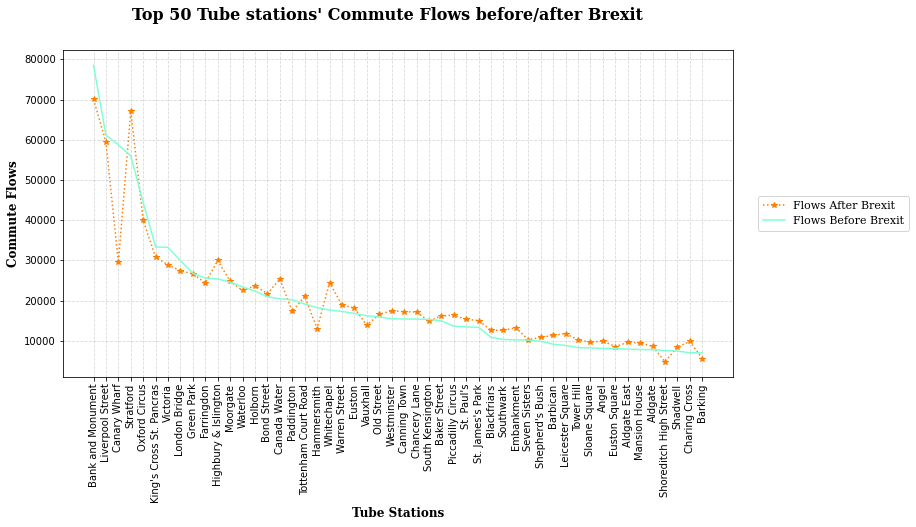

In [92]:
# plot before and after Brexit commute flows

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
fig.suptitle("Top 50 Tube stations' Commute Flows before/after Brexit",fontsize=16, font='Serif',  fontweight='bold')  

ax.plot(list(flow_diff["scenarioA_est"])[0:50],  linestyle = ':', color = '#FF8000', marker='*', label="Flows After Brexit")
ax.plot(list(flow_diff["flows"])[0:50], color ='#7FFFD4', label="Flows Before Brexit")

ax.grid(color="grey", linestyle="--", alpha=0.3)
ax.set_xlabel("Tube Stations", font='Serif', fontsize = 12, fontweight='bold')
ax.set_ylabel("Commute Flows", font='Serif', fontsize = 12, fontweight='bold')
ax.set_xticks(list(range(50)))
ax.set_xticklabels(list(flow_diff["station_destination"])[0:50], rotation=90)

# Move the legend to the right-hand side and set font
ax.legend(bbox_to_anchor=(1.03, 0.5), loc='center left', prop={'family': 'Serif', 'size': 11})
#plt.show()
plt.savefig('fig5.png', dpi=300, bbox_inches = "tight")

In [93]:
# R2 and RMSE of Origin-constrained model with inverse power law
print(f"R-squared of Negative Exponential Production Constrained model is {CalcRSqaured(flow_diff['flows'], flow_diff['scenarioA_est'])}")
print(f"RMSE of Negative Exponential Production Constrained model is {CalcRMSE(flow_diff['flows'], flow_diff['scenarioA_est'])}")

R-squared of Negative Exponential Production Constrained model is 0.9435414694364137
RMSE of Negative Exponential Production Constrained model is 1975.059


### 4.2. Scenario B

There is a significant increase in the cost of transport. Select 2 values for the parameter in the cost function reflecting scenario B. Recompute the **distribution of flows**. Here we use $beta$ from Production-constrained model with negative exponential. The beta value represents the extent to which distance affects the spatial interaction model, and increasing it would increase the weight given to distance in the model.

In [94]:
beta

0.0001528315796757068

In [95]:
df = london_flows.copy()

In [96]:
# let's give something realistic - 
beta_1 = beta * 2 # 200% 
beta_2 = beta * 5 # 500% increase

**Beta 1**

In [97]:
dj_gamma = df["jobs"] ** gamma  # use old jobs

# beta_1
dist_beta1 = np.exp(df["distance"] * -beta_1)

# calcualte the first stage of the Ai values
df["Ai1_sb1"] = dj_gamma * dist_beta1

# now do the sum over all js bit
A_i = pd.DataFrame(df.groupby(["station_origin"])["Ai1_sb1"].agg(np.sum))

# now divide into 1
A_i["A_i_sb1"] = 1 / A_i["Ai1_sb1"]
A_i.drop(['Ai1_sb1'], axis = 1, inplace = True)

# and write the A_i values back into the dataframe
df = df.merge(A_i, left_on="station_origin", right_index=True, how="left")

# remove "Ai1" column
df.drop(['Ai1_sb1'], axis=1, inplace=True)
df.head()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,doubsim_pow,doubsim_exp,prodSim_pow,O_i,D_j,alpha_i,prodSim_exp,jobs_scenario,A_i,scenarioA_est,A_i_sb1
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,55.0,77.0,55.0,599,78549,-2.918351,78.0,78549.0,0.000097,83,0.00015
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,2.0,3.0,1.0,599,442,-2.918351,1.0,442.0,0.000097,2,0.00015
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3.0,4.0,3.0,599,665,-2.918351,4.0,665.0,0.000097,4,0.00015
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,77.0,112.0,67.0,599,58772,-2.918351,100.0,29386.0,0.000097,63,0.00015
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,45.0,48.0,49.0,599,15428,-2.918351,56.0,15428.0,0.000097,60,0.00015


**Beta 2**

In [98]:
# beta_2
dist_beta2 = np.exp(df["distance"] * -beta_2)

# calcualte the first stage of the Ai values
df["Ai1_sb2"] = dj_gamma * dist_beta2

# now do the sum over all js bit
A_i2 = pd.DataFrame(df.groupby(["station_origin"])["Ai1_sb2"].agg(np.sum))

# now divide by 1
A_i2["A_i_sb2"] = 1 / A_i2["Ai1_sb2"]
A_i2.drop(['Ai1_sb2'], axis = 1, inplace = True)

# and write the A_i values back to the dataframe
df = df.merge(A_i2, left_on="station_origin", right_index=True, how="left")

# remove "Ai1" column
df.drop(['Ai1_sb2'], axis=1, inplace=True)
df.head()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,doubsim_pow,doubsim_exp,prodSim_pow,O_i,D_j,alpha_i,prodSim_exp,jobs_scenario,A_i,scenarioA_est,A_i_sb1,A_i_sb2
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,55.0,77.0,55.0,599,78549,-2.918351,78.0,78549.0,0.000097,83,0.00015,0.000373
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,2.0,3.0,1.0,599,442,-2.918351,1.0,442.0,0.000097,2,0.00015,0.000373
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3.0,4.0,3.0,599,665,-2.918351,4.0,665.0,0.000097,4,0.00015,0.000373
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,77.0,112.0,67.0,599,58772,-2.918351,100.0,29386.0,0.000097,63,0.00015,0.000373
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,45.0,48.0,49.0,599,15428,-2.918351,56.0,15428.0,0.000097,60,0.00015,0.000373


In [99]:
# plug into equation
df["scenarioB1"] = df["A_i_sb1"] * df["population"] * dj_gamma * dist_beta1
df["scenarioB1"] = round(df["scenarioB1"])

df["scenarioB2"] = df["A_i_sb2"] * df["population"] * dj_gamma * dist_beta2
df["scenarioB2"] = round(df["scenarioB2"])

# display estimates and real flows
df[["scenarioA_est", "scenarioB1", "scenarioB2", "flows"]]  

,scenarioA_est,scenarioB1,scenarioB2,flows
0,83,37.0,2.0,0
1,2,1.0,0.0,1
2,4,4.0,2.0,3
3,63,76.0,18.0,1
4,60,66.0,59.0,37
...,...,...,...,...
61408,107,51.0,2.0,127
61409,320,312.0,98.0,608
61410,39,33.0,7.0,6
61411,135,220.0,321.0,81


In [100]:
# Scenario_A
prodSim_exp_scenario_A

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,Archway,Arnos Grove,Arsenal,Baker Street,Balham,Bank and Monument,Barbican,Barking,Barkingside,Barons Court,Bayswater,Beckton,Beckton Park,Becontree,Belsize Park,Bermondsey,Bethnal Green,Blackfriars,Blackhorse Road,Blackwall,Bond Street,Borough,Boston Manor,Bounds Green,Bow Church,Bow Road,Brent Cross,Brentwood,Brixton,Brockley,Bromley-by-Bow,Brondesbury,Brondesbury Park,Bruce Grove,Buckhurst Hill,Burnt Oak,Bush Hill Park,Bushey,Caledonian Road,Caledonian Road & Barnsbury,Cambridge Heath,Camden Road,Camden Town,Canada Water,Canary Wharf,Canning Town,Cannon Street,Canonbury,Canons Park,Carpenders Park,Chadwell Heath,Chalfont & Latimer,Chalk Farm,Chancery Lane,Charing Cross,Chesham,Cheshunt,Chigwell,Chingford,Chiswick Park,Chorleywood,Clapham Common,Clapham High Street,Clapham Junction,Clapham North,Clapham South,Clapton,Cockfosters,Colindale,Colliers Wood,Covent Garden,Crossharbour,Crouch Hill,Croxley,Crystal Palace,Custom House,Cutty Sark,Cyprus,Dagenham East,Dagenham Heathway,Dalston Junction,Dalston Kingsland,Debden,Denmark Hill,Deptford Bridge,Devons Road,Dollis Hill,Ealing Broadway,Ealing Common,Earl's Court,East Acton,East Finchley,East Ham,East India,East Putney,Eastcote,Edgware,Edgware Road,Edmonton Green,Elephant & Castle,Elm Park,Elverson Road,Embankment,Emerson Park,Enfield Town,Epping,Euston,Euston Square,Fairlop,Farringdon,Finchley Central,Finchley Road,Finchley Road & Frognal,Finsbury Park,Forest Gate,Forest Hill,Fulham Broadway,Gallions Reach,Gants Hill,Gidea Park,Gloucester Road,Golders Green,Goldhawk Road,Goodge Street,Goodmayes,Gospel Oak,Grange Hill,Great Portland Street,Green Park,Greenford,Greenwich,Gunnersbury,Hackney Central,Hackney Downs,Hackney Wick,Haggerston,Hainault,Hammersmith,Hampstead,Hampstead Heath,Hanger Lane,Harlesden,Harold Wood,Harringay Green Lanes,Harrow & Wealdstone,Harrow-on-the-Hill,Hatch End,Hatton Cross,Headstone Lane,Heathrow Terminal 4,Heathrow Terminal 5,Heathrow Terminals 2 & 3,Hendon Central,Heron Quays,High Barnet,High Street Kensington,Highams Park,Highbury & Islington,Highgate,Hillingdon,Holborn,Holland Park,Holloway Road,Homerton,Honor Oak Park,Hornchurch,Hounslow Central,Hounslow East,Hounslow West,Hoxton,Hyde Park Corner,Ickenham,Ilford,Imperial Wharf,Island Gardens,Kennington,Kensal Green,Kensal Rise,Kensington,Kentish Town,Kentish Town West,Kenton,Kew Gardens,Kilburn,Kilburn High Road,Kilburn Park,King George V,King's Cross St. Pancras,Kingsbury,Knightsbridge,Ladbroke Grove,Lambeth North,Lancaster Gate,Langdon Park,Latimer Road,Leicester Square,Lewisham,Leyton,Leyton Midland Road,Leytonstone,Leytonstone High Road,Limehouse,Liverpool Street,London Bridge,London City Airport,London Fields,Loughton,Maida Vale,Manor House,Manor Park,Mansion House,Marble Arch,Maryland,Marylebone,Mile End,Mill Hill East,Moor Park,Moorgate,Morden,Mornington Crescent,Mudchute,Neasden,New Cross,New Cross Gate,Newbury Park,North Acton,North Ealing,North Greenwich,North Harrow,North Wembley,Northfields,Northolt,Northwick Park,Northwood,Northwood Hills,Norwood Junction,Notting Hill Gate,Oakwood,Old Street,Osterley,Oval,Oxford Circus,Paddington,Park Royal,Parsons Green,Peckham Rye,Penge West,Perivale,Piccadilly Circus,Pimlico,Pinner,Plaistow,Pontoon Dock,Poplar,Preston Road,Prince Regent,Pudding Mill Lane,Putney Bridge,Queen's Park,Queens Road Peckham,Queensbury,Queensway,Ravenscourt Park,Rayners Lane,Rectory Road,Redbridge,Regent's Park,Richmond,Rickmansworth,Roding Valley,Romford,Rotherhithe,Royal Albert,Royal Oak,Royal Victoria,Ruislip,Ruislip Gardens,Ruislip Manor,Russell Square,Seven Kings,Seven Sisters,Shadwell,Shenfield,Shepherd's Bush,Shepherd's Bush Market,Shoreditch High Street,Silver Street,Sloane Square,Snaresbrook,South Acton,South Ealing,South Hampstead,South Harrow,South Kensington,South Kenton,South Quay,South Ruislip,South Tottenham,South Wimbledon,South Woodford,Sou

In [101]:
# Scenario_B1
prodSim_exp_scenario_B1 = df.pivot_table(values="scenarioB1", index="station_origin",
                                       columns="station_destination", aggfunc=np.sum, margins=True)
prodSim_exp_scenario_B1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,Archway,Arnos Grove,Arsenal,Baker Street,Balham,Bank and Monument,Barbican,Barking,Barkingside,Barons Court,Bayswater,Beckton,Beckton Park,Becontree,Belsize Park,Bermondsey,Bethnal Green,Blackfriars,Blackhorse Road,Blackwall,Bond Street,Borough,Boston Manor,Bounds Green,Bow Church,Bow Road,Brent Cross,Brentwood,Brixton,Brockley,Bromley-by-Bow,Brondesbury,Brondesbury Park,Bruce Grove,Buckhurst Hill,Burnt Oak,Bush Hill Park,Bushey,Caledonian Road,Caledonian Road & Barnsbury,Cambridge Heath,Camden Road,Camden Town,Canada Water,Canary Wharf,Canning Town,Cannon Street,Canonbury,Canons Park,Carpenders Park,Chadwell Heath,Chalfont & Latimer,Chalk Farm,Chancery Lane,Charing Cross,Chesham,Cheshunt,Chigwell,Chingford,Chiswick Park,Chorleywood,Clapham Common,Clapham High Street,Clapham Junction,Clapham North,Clapham South,Clapton,Cockfosters,Colindale,Colliers Wood,Covent Garden,Crossharbour,Crouch Hill,Croxley,Crystal Palace,Custom House,Cutty Sark,Cyprus,Dagenham East,Dagenham Heathway,Dalston Junction,Dalston Kingsland,Debden,Denmark Hill,Deptford Bridge,Devons Road,Dollis Hill,Ealing Broadway,Ealing Common,Earl's Court,East Acton,East Finchley,East Ham,East India,East Putney,Eastcote,Edgware,Edgware Road,Edmonton Green,Elephant & Castle,Elm Park,Elverson Road,Embankment,Emerson Park,Enfield Town,Epping,Euston,Euston Square,Fairlop,Farringdon,Finchley Central,Finchley Road,Finchley Road & Frognal,Finsbury Park,Forest Gate,Forest Hill,Fulham Broadway,Gallions Reach,Gants Hill,Gidea Park,Gloucester Road,Golders Green,Goldhawk Road,Goodge Street,Goodmayes,Gospel Oak,Grange Hill,Great Portland Street,Green Park,Greenford,Greenwich,Gunnersbury,Hackney Central,Hackney Downs,Hackney Wick,Haggerston,Hainault,Hammersmith,Hampstead,Hampstead Heath,Hanger Lane,Harlesden,Harold Wood,Harringay Green Lanes,Harrow & Wealdstone,Harrow-on-the-Hill,Hatch End,Hatton Cross,Headstone Lane,Heathrow Terminal 4,Heathrow Terminal 5,Heathrow Terminals 2 & 3,Hendon Central,Heron Quays,High Barnet,High Street Kensington,Highams Park,Highbury & Islington,Highgate,Hillingdon,Holborn,Holland Park,Holloway Road,Homerton,Honor Oak Park,Hornchurch,Hounslow Central,Hounslow East,Hounslow West,Hoxton,Hyde Park Corner,Ickenham,Ilford,Imperial Wharf,Island Gardens,Kennington,Kensal Green,Kensal Rise,Kensington,Kentish Town,Kentish Town West,Kenton,Kew Gardens,Kilburn,Kilburn High Road,Kilburn Park,King George V,King's Cross St. Pancras,Kingsbury,Knightsbridge,Ladbroke Grove,Lambeth North,Lancaster Gate,Langdon Park,Latimer Road,Leicester Square,Lewisham,Leyton,Leyton Midland Road,Leytonstone,Leytonstone High Road,Limehouse,Liverpool Street,London Bridge,London City Airport,London Fields,Loughton,Maida Vale,Manor House,Manor Park,Mansion House,Marble Arch,Maryland,Marylebone,Mile End,Mill Hill East,Moor Park,Moorgate,Morden,Mornington Crescent,Mudchute,Neasden,New Cross,New Cross Gate,Newbury Park,North Acton,North Ealing,North Greenwich,North Harrow,North Wembley,Northfields,Northolt,Northwick Park,Northwood,Northwood Hills,Norwood Junction,Notting Hill Gate,Oakwood,Old Street,Osterley,Oval,Oxford Circus,Paddington,Park Royal,Parsons Green,Peckham Rye,Penge West,Perivale,Piccadilly Circus,Pimlico,Pinner,Plaistow,Pontoon Dock,Poplar,Preston Road,Prince Regent,Pudding Mill Lane,Putney Bridge,Queen's Park,Queens Road Peckham,Queensbury,Queensway,Ravenscourt Park,Rayners Lane,Rectory Road,Redbridge,Regent's Park,Richmond,Rickmansworth,Roding Valley,Romford,Rotherhithe,Royal Albert,Royal Oak,Royal Victoria,Ruislip,Ruislip Gardens,Ruislip Manor,Russell Square,Seven Kings,Seven Sisters,Shadwell,Shenfield,Shepherd's Bush,Shepherd's Bush Market,Shoreditch High Street,Silver Street,Sloane Square,Snaresbrook,South Acton,South Ealing,South Hampstead,South Harrow,South Kensington,South Kenton,South Quay,South Ruislip,South Tottenham,South Wimbledon,South Woodford,Sou

In [102]:
# Scenario_B2
prodSim_exp_scenario_B2 = df.pivot_table(values="scenarioB2", index="station_origin",
                                       columns="station_destination", aggfunc=np.sum, margins=True)
prodSim_exp_scenario_B2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,Archway,Arnos Grove,Arsenal,Baker Street,Balham,Bank and Monument,Barbican,Barking,Barkingside,Barons Court,Bayswater,Beckton,Beckton Park,Becontree,Belsize Park,Bermondsey,Bethnal Green,Blackfriars,Blackhorse Road,Blackwall,Bond Street,Borough,Boston Manor,Bounds Green,Bow Church,Bow Road,Brent Cross,Brentwood,Brixton,Brockley,Bromley-by-Bow,Brondesbury,Brondesbury Park,Bruce Grove,Buckhurst Hill,Burnt Oak,Bush Hill Park,Bushey,Caledonian Road,Caledonian Road & Barnsbury,Cambridge Heath,Camden Road,Camden Town,Canada Water,Canary Wharf,Canning Town,Cannon Street,Canonbury,Canons Park,Carpenders Park,Chadwell Heath,Chalfont & Latimer,Chalk Farm,Chancery Lane,Charing Cross,Chesham,Cheshunt,Chigwell,Chingford,Chiswick Park,Chorleywood,Clapham Common,Clapham High Street,Clapham Junction,Clapham North,Clapham South,Clapton,Cockfosters,Colindale,Colliers Wood,Covent Garden,Crossharbour,Crouch Hill,Croxley,Crystal Palace,Custom House,Cutty Sark,Cyprus,Dagenham East,Dagenham Heathway,Dalston Junction,Dalston Kingsland,Debden,Denmark Hill,Deptford Bridge,Devons Road,Dollis Hill,Ealing Broadway,Ealing Common,Earl's Court,East Acton,East Finchley,East Ham,East India,East Putney,Eastcote,Edgware,Edgware Road,Edmonton Green,Elephant & Castle,Elm Park,Elverson Road,Embankment,Emerson Park,Enfield Town,Epping,Euston,Euston Square,Fairlop,Farringdon,Finchley Central,Finchley Road,Finchley Road & Frognal,Finsbury Park,Forest Gate,Forest Hill,Fulham Broadway,Gallions Reach,Gants Hill,Gidea Park,Gloucester Road,Golders Green,Goldhawk Road,Goodge Street,Goodmayes,Gospel Oak,Grange Hill,Great Portland Street,Green Park,Greenford,Greenwich,Gunnersbury,Hackney Central,Hackney Downs,Hackney Wick,Haggerston,Hainault,Hammersmith,Hampstead,Hampstead Heath,Hanger Lane,Harlesden,Harold Wood,Harringay Green Lanes,Harrow & Wealdstone,Harrow-on-the-Hill,Hatch End,Hatton Cross,Headstone Lane,Heathrow Terminal 4,Heathrow Terminal 5,Heathrow Terminals 2 & 3,Hendon Central,Heron Quays,High Barnet,High Street Kensington,Highams Park,Highbury & Islington,Highgate,Hillingdon,Holborn,Holland Park,Holloway Road,Homerton,Honor Oak Park,Hornchurch,Hounslow Central,Hounslow East,Hounslow West,Hoxton,Hyde Park Corner,Ickenham,Ilford,Imperial Wharf,Island Gardens,Kennington,Kensal Green,Kensal Rise,Kensington,Kentish Town,Kentish Town West,Kenton,Kew Gardens,Kilburn,Kilburn High Road,Kilburn Park,King George V,King's Cross St. Pancras,Kingsbury,Knightsbridge,Ladbroke Grove,Lambeth North,Lancaster Gate,Langdon Park,Latimer Road,Leicester Square,Lewisham,Leyton,Leyton Midland Road,Leytonstone,Leytonstone High Road,Limehouse,Liverpool Street,London Bridge,London City Airport,London Fields,Loughton,Maida Vale,Manor House,Manor Park,Mansion House,Marble Arch,Maryland,Marylebone,Mile End,Mill Hill East,Moor Park,Moorgate,Morden,Mornington Crescent,Mudchute,Neasden,New Cross,New Cross Gate,Newbury Park,North Acton,North Ealing,North Greenwich,North Harrow,North Wembley,Northfields,Northolt,Northwick Park,Northwood,Northwood Hills,Norwood Junction,Notting Hill Gate,Oakwood,Old Street,Osterley,Oval,Oxford Circus,Paddington,Park Royal,Parsons Green,Peckham Rye,Penge West,Perivale,Piccadilly Circus,Pimlico,Pinner,Plaistow,Pontoon Dock,Poplar,Preston Road,Prince Regent,Pudding Mill Lane,Putney Bridge,Queen's Park,Queens Road Peckham,Queensbury,Queensway,Ravenscourt Park,Rayners Lane,Rectory Road,Redbridge,Regent's Park,Richmond,Rickmansworth,Roding Valley,Romford,Rotherhithe,Royal Albert,Royal Oak,Royal Victoria,Ruislip,Ruislip Gardens,Ruislip Manor,Russell Square,Seven Kings,Seven Sisters,Shadwell,Shenfield,Shepherd's Bush,Shepherd's Bush Market,Shoreditch High Street,Silver Street,Sloane Square,Snaresbrook,South Acton,South Ealing,South Hampstead,South Harrow,South Kensington,South Kenton,South Quay,South Ruislip,South Tottenham,South Wimbledon,South Woodford,Sou

In [103]:
# Original
london_flows_pivot_pc_exp

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,Archway,Arnos Grove,Arsenal,Baker Street,Balham,Bank and Monument,Barbican,Barking,Barkingside,Barons Court,Bayswater,Beckton,Beckton Park,Becontree,Belsize Park,Bermondsey,Bethnal Green,Blackfriars,Blackhorse Road,Blackwall,Bond Street,Borough,Boston Manor,Bounds Green,Bow Church,Bow Road,Brent Cross,Brentwood,Brixton,Brockley,Bromley-by-Bow,Brondesbury,Brondesbury Park,Bruce Grove,Buckhurst Hill,Burnt Oak,Bush Hill Park,Bushey,Caledonian Road,Caledonian Road & Barnsbury,Cambridge Heath,Camden Road,Camden Town,Canada Water,Canary Wharf,Canning Town,Cannon Street,Canonbury,Canons Park,Carpenders Park,Chadwell Heath,Chalfont & Latimer,Chalk Farm,Chancery Lane,Charing Cross,Chesham,Cheshunt,Chigwell,Chingford,Chiswick Park,Chorleywood,Clapham Common,Clapham High Street,Clapham Junction,Clapham North,Clapham South,Clapton,Cockfosters,Colindale,Colliers Wood,Covent Garden,Crossharbour,Crouch Hill,Croxley,Crystal Palace,Custom House,Cutty Sark,Cyprus,Dagenham East,Dagenham Heathway,Dalston Junction,Dalston Kingsland,Debden,Denmark Hill,Deptford Bridge,Devons Road,Dollis Hill,Ealing Broadway,Ealing Common,Earl's Court,East Acton,East Finchley,East Ham,East India,East Putney,Eastcote,Edgware,Edgware Road,Edmonton Green,Elephant & Castle,Elm Park,Elverson Road,Embankment,Emerson Park,Enfield Town,Epping,Euston,Euston Square,Fairlop,Farringdon,Finchley Central,Finchley Road,Finchley Road & Frognal,Finsbury Park,Forest Gate,Forest Hill,Fulham Broadway,Gallions Reach,Gants Hill,Gidea Park,Gloucester Road,Golders Green,Goldhawk Road,Goodge Street,Goodmayes,Gospel Oak,Grange Hill,Great Portland Street,Green Park,Greenford,Greenwich,Gunnersbury,Hackney Central,Hackney Downs,Hackney Wick,Haggerston,Hainault,Hammersmith,Hampstead,Hampstead Heath,Hanger Lane,Harlesden,Harold Wood,Harringay Green Lanes,Harrow & Wealdstone,Harrow-on-the-Hill,Hatch End,Hatton Cross,Headstone Lane,Heathrow Terminal 4,Heathrow Terminal 5,Heathrow Terminals 2 & 3,Hendon Central,Heron Quays,High Barnet,High Street Kensington,Highams Park,Highbury & Islington,Highgate,Hillingdon,Holborn,Holland Park,Holloway Road,Homerton,Honor Oak Park,Hornchurch,Hounslow Central,Hounslow East,Hounslow West,Hoxton,Hyde Park Corner,Ickenham,Ilford,Imperial Wharf,Island Gardens,Kennington,Kensal Green,Kensal Rise,Kensington,Kentish Town,Kentish Town West,Kenton,Kew Gardens,Kilburn,Kilburn High Road,Kilburn Park,King George V,King's Cross St. Pancras,Kingsbury,Knightsbridge,Ladbroke Grove,Lambeth North,Lancaster Gate,Langdon Park,Latimer Road,Leicester Square,Lewisham,Leyton,Leyton Midland Road,Leytonstone,Leytonstone High Road,Limehouse,Liverpool Street,London Bridge,London City Airport,London Fields,Loughton,Maida Vale,Manor House,Manor Park,Mansion House,Marble Arch,Maryland,Marylebone,Mile End,Mill Hill East,Moor Park,Moorgate,Morden,Mornington Crescent,Mudchute,Neasden,New Cross,New Cross Gate,Newbury Park,North Acton,North Ealing,North Greenwich,North Harrow,North Wembley,Northfields,Northolt,Northwick Park,Northwood,Northwood Hills,Norwood Junction,Notting Hill Gate,Oakwood,Old Street,Osterley,Oval,Oxford Circus,Paddington,Park Royal,Parsons Green,Peckham Rye,Penge West,Perivale,Piccadilly Circus,Pimlico,Pinner,Plaistow,Pontoon Dock,Poplar,Preston Road,Prince Regent,Pudding Mill Lane,Putney Bridge,Queen's Park,Queens Road Peckham,Queensbury,Queensway,Ravenscourt Park,Rayners Lane,Rectory Road,Redbridge,Regent's Park,Richmond,Rickmansworth,Roding Valley,Romford,Rotherhithe,Royal Albert,Royal Oak,Royal Victoria,Ruislip,Ruislip Gardens,Ruislip Manor,Russell Square,Seven Kings,Seven Sisters,Shadwell,Shenfield,Shepherd's Bush,Shepherd's Bush Market,Shoreditch High Street,Silver Street,Sloane Square,Snaresbrook,South Acton,South Ealing,South Hampstead,South Harrow,South Kensington,South Kenton,South Quay,South Ruislip,South Tottenham,South Wimbledon,South Woodford,Sou

**Potential ways of assessing the impact of scenarios on commute flow redistribution**
- Root Mean Squared Error (RMSE): RMSE measures the difference between the actual and predicted flows. A higher RMSE indicates a larger difference between the actual and predicted flows, which means that the scenario has a greater impact on the redistribution of flows.

- Mean Absolute Percentage Error (MAPE): MAPE measures the percentage difference between the actual and predicted flows. A higher MAPE indicates a larger percentage difference between the actual and predicted flows, which means that the scenario has a greater impact on the redistribution of flows.

- Gini coefficient: Gini coefficient measures the inequality in the distribution of flows. A higher Gini coefficient indicates a greater level of inequality in the distribution of flows, which means that the scenario has a greater impact on the redistribution of flows.

- Lorenz curve: The Lorenz curve is a graphical representation of the distribution of flows. By comparing the Lorenz curves for different scenarios, you can visually see the impact of each scenario on the redistribution of flows.

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# ensure your arr is sorted from lowest to highest values first!
#arr = np.array([1,4,6,9,100])

def gini(arr):
    count = arr.size
    coefficient = 2 / count
    indexes = np.arange(1, count + 1)
    weighted_sum = (indexes * arr).sum()
    total = arr.sum()
    constant = (count + 1) / count
    return coefficient * weighted_sum / total - constant

def lorenz(arr):
    # this divides the prefix sum by the total sum
    # this ensures all the values are between 0 and 1.0
    scaled_prefix_sum = arr.cumsum() / arr.sum()
    # this prepends the 0 value (because 0% of all people have 0% of all wealth)
    return np.insert(scaled_prefix_sum, 0, 0)


In [105]:
# calculate Gini coefficient for scenarioA_est
gini_scenarioA = gini(df['scenarioA_est'].sort_values(ascending=True))

# calculate Gini coefficient for scenarioB1
gini_scenarioB1 = gini(df['scenarioB1'].sort_values(ascending=True))

# calculate Gini coefficient for scenarioB2
gini_scenarioB2 = gini(df['scenarioB2'].sort_values(ascending=True))

# calculate Gini coefficient for original flows
gini_flows = gini(df['flows'].sort_values(ascending=True))

print("Gini coefficient for scenarioA_est:", gini_scenarioA)
print("Gini coefficient for scenarioB1:", gini_scenarioB1)
print("Gini coefficient for scenarioB2:", gini_scenarioB2)
print("Gini coefficient for original flows:", gini_flows)


Gini coefficient for scenarioA_est: 0.7784333742643361
Gini coefficient for scenarioB1: 0.8589870729562492
Gini coefficient for scenarioB2: 0.9581708425301614
Gini coefficient for original flows: 0.856902694937246


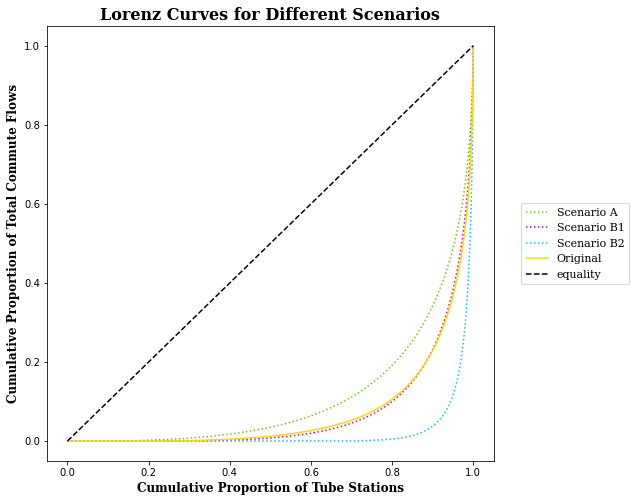

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def lorenz(arr):
    # this divides the prefix sum by the total sum
    # this ensures all the values are between 0 and 1.0
    scaled_prefix_sum = arr.cumsum() / arr.sum()
    # this prepends the 0 value (because 0% of all people have 0% of all wealth)
    return np.insert(scaled_prefix_sum, 0, 0)

# sort the data by each column
dfA = df.sort_values(by='scenarioA_est', ascending=True)
dfB1 = df.sort_values(by='scenarioB1', ascending=True)
dfB2 = df.sort_values(by='scenarioB2', ascending=True)
dfFlows = df.sort_values(by='flows', ascending=True)

# calculate the Lorenz curves
lorenz_A = lorenz(dfA['scenarioA_est'].values)
lorenz_B1 = lorenz(dfB1['scenarioB1'].values)
lorenz_B2 = lorenz(dfB2['scenarioB2'].values)
lorenz_Flows = lorenz(dfFlows['flows'].values)

# plot the Lorenz curves
plt.figure(figsize=(8,8))
plt.plot(np.linspace(0,1,len(lorenz_A)), lorenz_A, label='Scenario A', linestyle = ':', color = '#66CD00')
plt.plot(np.linspace(0,1,len(lorenz_B1)), lorenz_B1, label='Scenario B1', linestyle = ':',color = 'm')
plt.plot(np.linspace(0,1,len(lorenz_B2)), lorenz_B2, label='Scenario B2', linestyle = ':',  color = '#00BFFF') 
plt.plot(np.linspace(0,1,len(lorenz_Flows)), lorenz_Flows, label='Original', color = 'gold')
plt.plot([0,1], [0,1], 'k--', label='equality')
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', prop={'family': 'Serif', 'size': 11})
plt.xlabel('Cumulative Proportion of Tube Stations', font='Serif', fontsize = 12, fontweight='bold')
plt.ylabel('Cumulative Proportion of Total Commute Flows', font='Serif', fontsize = 12, fontweight='bold')
plt.title('Lorenz Curves for Different Scenarios', fontsize=16, font='Serif',  fontweight='bold')
#plt.show()
plt.savefig("fig6.png",dpi=300, bbox_inches = "tight")

In [107]:
end_time = time.time()
run_time = end_time - start_time
print("Total run time: ", run_time, "seconds")

Total run time:  226.02164959907532 seconds
